In [1]:
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)


Toggle code

In [2]:
# all modules necessary for this nb
import os
import sys
import pickle
import math

import numpy as np
import pylab as pl
import scipy.stats as sstats

# setting parameters for default matplotlib plots
%matplotlib inline

In [3]:
pl.style.use('fabiostyle')
# needs to find the library of functions
sys.path.append('../../code/')  # to be replaced!

import utils as ut
import plots as pt

In [4]:
#%%javascript
#var nb = IPython.notebook;
#var kernel = IPython.notebook.kernel;
#var command = "NOTEBOOK_NAME = '" + nb.base_url + nb.notebook_path + "'";
#kernel.execute(command);

In [5]:
NOTEBOOK_NAME = 'heatmaps_vhpc'

In [6]:
from pickleshare import PickleShareDB

autorestore_folder = os.path.join(os.getcwd(), 'autorestore', NOTEBOOK_NAME)
db = PickleShareDB(autorestore_folder)
import sys
from workspace import *
import IPython
ip = IPython.get_ipython()

# this will restore all the saved variables. ignore the errors listed.
load_workspace(ip, db)

# use `save_worspace(db)` to save variables at the end

In [7]:
#exclude c10m6 (dentate animal)
expo_animals = 'c3m1', 'c3m2', 'c3f3', 'c10m8'
pre_animals = 'c3m2', 'c3f3', 'c10m8' #c3m1 has funky time_ax single (length is not consistent across trials)
post_animals = '90','90_475','91','93_500','93_580','93_720','93_810','c3m1', 'c3m2', 'c3f3', 'c10m8'
#context_switch_animals = '90','93_720','93_810','c3m1','c3m1_725','c3m2','c3m2_645','c3f3','c10m8'

In [8]:
sessions = 'expo', 'pre', 'post'
session_labels = 'Pre','Early','Late'
dark_co = ('forestgreen','darkcyan','firebrick')

In [9]:
for sess in sessions[1:]:
    exec("%s_anivars = {}"%sess)
    for animal in eval("%s_animals"%sess):
        exec("vars_%s = {}"%sess)
        folder = '../%s/%s/notebooks/autorestore/preprocessing/' % (animal,sess)
        for var in ('time_ax', 'time_ax_single', 'events', 'cycles','is_rewardt','is_CSmt', 'is_STIM1t','is_STIM2t','is_STIM3t',
                    'is_STIM4t','is_STIM5t','is_STIM6t','is_STIM7t','is_STIM8t','traces','traces_raw', 'CYCLE_START', 'CS_DURATION'): 
            eval("vars_%s"%sess).update({var:ut.load_variable(var, folder=folder)})
            
        eval("%s_anivars"%sess).update({animal:{}})
        eval("%s_anivars[animal]"%(sess)).update({eval("'vars_%s'"%sess):eval("vars_%s"%sess)})


In [10]:
for sess in ['expo']:
    exec("%s_anivars = {}"%sess)
    for animal in eval("%s_animals"%sess):
        exec("vars_%s = {}"%sess)
        folder = '../%s/4_odor_expo/notebooks/autorestore/preprocessing/' % (animal)
        for var in ('time_ax', 'time_ax_single', 'events', 'cycles','is_rewardt','is_CSmt', 'is_STIM1t','is_STIM2t','is_STIM3t',
                    'is_STIM4t','is_STIM5t','is_STIM6t','is_STIM7t','is_STIM8t','traces','traces_raw', 'CYCLE_START', 'CS_DURATION'): 
            eval("vars_%s"%sess).update({var:ut.load_variable(var, folder=folder)})
            
        eval("%s_anivars"%sess).update({animal:{}})
        eval("%s_anivars[animal]"%(sess)).update({eval("'vars_%s'"%sess):eval("vars_%s"%sess)})

### look at event amplitude

for sess in sessions:
    exec("all_amps_%s_CSm_evs=[]"%sess)
    exec("all_amps_%s_Rew_evs=[]"%sess)
    for animal in eval("%s_animals"%sess):
    #    cellregs = anivars[animal]['cellregs']
        exec("vars_%s = %s_anivars['%s']['vars_%s']"%(sess,sess,animal,sess))
    
        for k in eval("vars_%s.keys()"%sess):
            exec('%s = vars_%s[\'%s\']' % (k,sess,k))
    
        exec("amp_%s_CSm_evs = np.r_[[ut.compute_all_dffs(time_ax, events, cell, cycles[is_CSmt], time_ax_single)\
                        for cell in range(len(vars_%s['events'][0]))]]"%(sess,sess))
        #exec("amp_%s_CSm_evs = np.r_[[h for h in amp_%s_CSm_evs]]"%(sess,sess))
        #exec("amp_%s_CSm_evs = np.r_[[np.mean(h, 0)/np.std(h, 0) if zscored else np.mean(h, 0)/np.max(h.mean(0)) for h in amp_%s_CSm_evs]]"%(sess,sess))
        exec("amp_%s_Rew_evs = np.r_[[ut.compute_all_dffs(time_ax, events, cell, cycles[is_rewardt], time_ax_single)\
                        for cell in range(len(vars_%s['events'][0]))]]"%(sess,sess))
        #exec("amp_%s_Rew_evs = np.r_[[np.mean(h, 0)/np.std(h, 0) if zscored else np.mean(h, 0)/np.max(h.mean(0)) for h in amp_%s_Rew_evs]]"%(sess,sess))
        
        eval("all_amps_%s_CSm_evs.append(amp_%s_CSm_evs)"%(sess, sess))
        eval("all_amps_%s_Rew_evs.append(amp_%s_Rew_evs)"%(sess, sess))

#### all_amps_d2_CSm_evs[anis][cells][trials][time bins]

# make list of all events across all animals, cells, trials, time bins (will wanna restrict time bins to odor, trace, etc, later)
for tt in ['CSm','Rew']:
    exec("all_%s_evs=[]"%(tt))
    for sess in sessions:
        for ani in range(len(eval("all_amps_%s_%s_evs"%(sess,tt)))):
            #print i, all_amps_d2_CSm_evs[i]
            for cell in range(len(eval("all_amps_%s_%s_evs[ani]"%(sess,tt)))):
                for trial in range(len(eval("all_amps_%s_%s_evs[ani][cell]"%(sess,tt)))):
                    for tb in eval("all_amps_%s_%s_evs[ani][cell][trial]"%(sess,tt)):
                        if tb > 0.0:
                            exec("all_%s_evs.append(tb)"%(tt))

# make list of all events across all animals, cells, trials, time bins by session.
for tt in ['CSm','Rew']:
    for sess in sessions:
        exec("all_%s_%s_evs=[]"%(sess,tt))
        for ani in range(len(eval("all_amps_%s_%s_evs"%(sess,tt)))):
            #print i, all_amps_d2_CSm_evs[i]
            for cell in range(len(eval("all_amps_%s_%s_evs[ani]"%(sess,tt)))):
                for trial in range(len(eval("all_amps_%s_%s_evs[ani][cell]"%(sess,tt)))):
                    for tb in eval("all_amps_%s_%s_evs[ani][cell][trial]"%(sess,tt)):
                        if tb > 0.0:
                            exec("all_%s_%s_evs.append(tb)"%(sess,tt))

for tt in ['CSm','Rew']:
    for sess in sessions:
        print sess,tt, 'mean:',
        print np.mean(eval("all_%s_%s_evs"%(sess,tt))), 'std:',
        print np.std(eval("all_%s_%s_evs"%(sess,tt)))

##this takes a while
# make list of all events across all animals, cells, trials, time bins by session AND BY EPOCH.
for epoch,s,e in zip(['CS','tr','US','longUS'],[1.0,3.0,5.0,5.0],[2.0,4.0,6.0,9.0]):
    for tt in ['CSm','Rew']:
        for sess in sessions:
            print 'working on %s %s %s      '%(epoch,tt,sess),
            exec("%s_%s_%s_evs=[]"%(epoch,sess,tt))
            for ani in range(len(eval("all_amps_%s_%s_evs"%(sess,tt)))):
                for cell in range(len(eval("all_amps_%s_%s_evs[ani]"%(sess,tt)))):
                    for trial in range(len(eval("all_amps_%s_%s_evs[ani][cell]"%(sess,tt)))):
                        for tb in range(len(eval("all_amps_%s_%s_evs[ani][cell][trial]"%(sess,tt)))):
                            if eval("%s_anivars[%s_animals[ani]]['vars_%s']['time_ax_single'][tb]"%(sess,sess,sess)) >= s:
                                if eval("%s_anivars[%s_animals[ani]]['vars_%s']['time_ax_single'][tb]"%(sess,sess,sess)) <= e:
                                    if eval("all_amps_%s_%s_evs[ani][cell][trial][tb]"%(sess,tt)) > 0.0:
                                        exec("%s_%s_%s_evs.append(all_amps_%s_%s_evs[ani][cell][trial][tb])"%(epoch,sess,tt,sess,tt))

for epoch in ['CS','tr','US','longUS']:
    for tt in ['CSm','Rew']:
        for sess in sessions:
            print epoch,tt,sess,'mean: ',
            print np.mean(eval("%s_%s_%s_evs"%(epoch,sess,tt)))

### extract trace "event" durations (a.k.a. widths)

general strategy will be to crudely ID events, take mean and std of the leftover trace "baseline", then ID events more finely using the mean/std that was just defined.
event stipulations: greater than 4SD above noise (baseline std), duration is as long as it stays above 4SD. trace must be above 4SDs for at least 4 time points (to minimize false positives)

##extract raw traces
for sess in sessions:
    exec("all_dur_%s_CSm_raw=[]"%sess)
    exec("all_dur_%s_Rew_raw=[]"%sess)
    for animal in eval("%s_animals"%sess):
    #    cellregs = anivars[animal]['cellregs']
        exec("vars_%s = %s_anivars['%s']['vars_%s']"%(sess,sess,animal,sess))
    
        for k in eval("vars_%s.keys()"%sess):
            exec('%s = vars_%s[\'%s\']' % (k,sess,k))
    
        exec("dur_%s_CSm_raw = np.r_[[ut.compute_all_dffs(time_ax, traces_raw, cell, cycles[is_CSmt], time_ax_single)\
                        for cell in range(len(vars_%s['traces_raw'][0]))]]"%(sess,sess))
        exec("dur_%s_Rew_raw = np.r_[[ut.compute_all_dffs(time_ax, traces_raw, cell, cycles[is_rewardt], time_ax_single)\
                        for cell in range(len(vars_%s['traces_raw'][0]))]]"%(sess,sess))
        
        eval("all_dur_%s_CSm_raw.append(dur_%s_CSm_raw)"%(sess, sess))
        eval("all_dur_%s_Rew_raw.append(dur_%s_Rew_raw)"%(sess, sess))

#truncate extra time bins if necessary and collect all cells across all animals into 1 array
for sess in sessions:
    for trialtype in ('CSm','Rew'):
        exec("max_t = np.min([a.shape[2] for a in all_dur_%s_%s_raw])"%(sess,trialtype))
        exec("all_dur_%s_%s_rawA = np.row_stack([a[:,:, :max_t] for a in all_dur_%s_%s_raw])"%(sess,trialtype,sess,trialtype))
        exec("min_time_ax_single_%s = vars_%s['time_ax_single'][:max_t]"%(sess,sess))
    #print max_t

##collapse all trails into same list (one for each cell)
for sess in sessions:
    for tt in ('CSm','Rew'):
        exec("all_data_by_cell_%s_%s_raw = {}"%(sess,tt))
        for cell in range(len(eval("all_dur_%s_%s_rawA"%(sess,tt)))):
            exec("all_data_by_cell_%s_%s_raw[cell] = []"%(sess,tt))
            for trial in range(len(eval("all_dur_%s_%s_rawA[cell]"%(sess,tt)))):
                for x in eval("all_dur_%s_%s_rawA[cell][trial]"%(sess,tt)):
                    exec("all_data_by_cell_%s_%s_raw[cell].append(x)"%(sess,tt))

##z-score the above
for sess in sessions:
    for tt in ('CSm','Rew'):
        exec("zs_all_data_by_cell_%s_%s_raw = {}"%(sess,tt))
        for cell in eval("all_data_by_cell_%s_%s_raw"%(sess,tt)):
            exec("zs_all_data_by_cell_%s_%s_raw[cell] = []"%(sess,tt))
            sd = np.std(eval("all_data_by_cell_%s_%s_raw[cell]"%(sess,tt)))
            for tb in eval("all_data_by_cell_%s_%s_raw[cell]"%(sess,tt)):
                exec("zs_all_data_by_cell_%s_%s_raw[cell].append(tb/sd)"%(sess,tt))

#make dictionary with tied list entries for 'event' and 'timebin'. iterate counter when a tb is above a STD threshold. if trace falls below SD thresh, reset counter
#if consecutive tbs above SD thresh are >= dur thresh, then grab the previous number of tbs equal to the value of dur_thresh and add them to the dictionary.
#continue adding new tbs/values to respective dictionary entries until trace falls below SD thresh
# can take the length of each event entry to get histogram of event durations

# Now extract the trace values and accompanying time bins of individual events
SD_thresh = 3
dur_thresh = 3
for sess in sessions:
    for tt in ('CSm','Rew'):
        exec("zs_extracted_%s_%s_raw = {}"%(sess,tt))  # make a dictionary; each entry is a neuron
        for cell in range(len(eval("zs_all_data_by_cell_%s_%s_raw"%(sess,tt)))):
            events=-1 # initialize the events counter for each new neuron (start at -1 so the first entry will actually be 0)
            duration_counter=0
            exec("zs_extracted_%s_%s_raw[cell] = {}"%(sess,tt))   # make a dictionary for individual events (& associated tbs)
            for tb,i in zip(eval("zs_all_data_by_cell_%s_%s_raw[cell]"%(sess,tt)),range(len(eval("zs_all_data_by_cell_%s_%s_raw[cell]"%(sess,tt))))):
                if tb >= SD_thresh: #if the zscore is higher than the SD threshold for event detection
                    duration_counter = duration_counter + 1 #increment the duration counter
                    if duration_counter == dur_thresh: #when an event crosses threshold
                        events = events+1
                        exec("zs_extracted_%s_%s_raw[cell]['event_%s'] = []"%(sess,tt,events)) #create a new dict entry for event values
                        exec("zs_extracted_%s_%s_raw[cell]['tb_%s'] = []"%(sess,tt,events)) #create a new dict entry for time bins that correspond to event values
                        for x in range(dur_thresh): #go back and populate list with values that are part of event, but prior to crossing dur_thresh
                            eval("zs_extracted_%s_%s_raw[cell]['event_%s']"%(sess,tt,events)).insert(x,
                                          eval("zs_all_data_by_cell_%s_%s_raw[cell][i-dur_thresh+x+1]"%(sess,tt)))
                            eval("zs_extracted_%s_%s_raw[cell]['tb_%s']"%(sess,tt,events)).insert(x,i-dur_thresh+x+1)
                    if duration_counter > dur_thresh: #continue to populate the list for as long as values > SD thresh
                        eval("zs_extracted_%s_%s_raw[cell]['event_%s']"%(sess,tt,events)).insert(duration_counter,tb)
                        eval("zs_extracted_%s_%s_raw[cell]['tb_%s']"%(sess,tt,events)).insert(duration_counter,i)
                    if duration_counter > 50: #if duration is super long (>5s), it's highly likely due to drifting baseline. DELETE IT
                        exec("del zs_extracted_%s_%s_raw[cell]['event_%s'][:]"%(sess,tt,events)) # delete the entry
                        exec("del zs_extracted_%s_%s_raw[cell]['tb_%s'][:]"%(sess,tt,events)) # delete the entry
                        #events = events -1 # decrement the event counter so we can overwrite this BS (and now empty) list
                        #duration_counter = 0 # reset the duration counter
                if tb < SD_thresh:
                    duration_counter = 0 # reset the duration counter

#extract the event durations
for sess in sessions:
    for tt in ('CSm','Rew'):
        exec("zs_durations_%s_%s_raw = []"%(sess,tt))
        for cell in range(len(eval("zs_extracted_%s_%s_raw"%(sess,tt)))):
            for event in range(len(eval("zs_extracted_%s_%s_raw[cell]"%(sess,tt)))/2):
                exec("zs_durations_%s_%s_raw.append(len(zs_extracted_%s_%s_raw[cell]['event_%s']))"%(sess,tt,sess,tt,event))

for sess in sessions:
    for tt in ('CSm','Rew'):
        print sess,tt,'mean:',
        print np.mean(eval("zs_durations_%s_%s_raw"%(sess,tt))), '    StDev:',
        print np.std(eval("zs_durations_%s_%s_raw"%(sess,tt)))

pl.hist(zs_durations_post_Rew_raw,bins=20)
pl.show()

#extract the event max values
for sess in sessions:
    for tt in ('CSm','Rew'):
        exec("zs_maxval_%s_%s_raw = []"%(sess,tt))
        for cell in range(len(eval("zs_extracted_%s_%s_raw"%(sess,tt)))):
            for event in range(len(eval("zs_extracted_%s_%s_raw[cell]"%(sess,tt)))/2):
                try:
                    exec("zs_maxval_%s_%s_raw.append(np.max(zs_extracted_%s_%s_raw[cell]['event_%s']))"%(sess,tt,sess,tt,event))
                except:
                    print 'failed on %s %s, cell: %s, event: %s'%(sess,tt,cell,event)

for sess in sessions:
    for tt in ('CSm','Rew'):
        print sess,tt,'mean:',
        print np.mean(eval("zs_maxval_%s_%s_raw"%(sess,tt))), '    StDev:',
        print np.std(eval("zs_maxval_%s_%s_raw"%(sess,tt)))

pl.hist(zs_maxval_d2_Rew_raw,bins=20)
pl.show()

## an alternative method for durations (where split up by time period)


##this takes a while
# make list of all events across all animals, cells, trials, time bins by session AND BY EPOCH.
SD_thresh = 1.5
dur_thresh = 3
for epoch,s,e in zip(['baseline','trial'],[-5.0,1.0],[0.0,7.0]):
    for tt in ['CSm','Rew']:
        for sess in sessions:
            cells=-1 #initialize total cell count for each new session
            print 'working on %s %s %s      '%(epoch,sess,tt),
            exec("dur_%s_%s_%s_raw={}"%(epoch,sess,tt))
            for cell in range(len(eval("zs_all_data_by_cell_%s_%s_raw"%(sess,tt)))):
                exec("dur_%s_%s_%s_raw[cell] = {}"%(epoch,sess,tt)) #initialize for all cells
            for ani in range(len(eval("all_dur_%s_%s_raw"%(sess,tt)))):
                for cell in range(len(eval("all_dur_%s_%s_raw[ani]"%(sess,tt)))):
                    cells=cells+1
                    events=-1 # initialize the events counter for each new neuron (start at -1 so the first entry will actually be 0)
                    duration_counter=0
                    for trial in range(len(eval("all_dur_%s_%s_raw[ani][cell]"%(sess,tt)))):
                        for tb,i in zip(eval("all_dur_%s_%s_raw[ani][cell][trial]"%(sess,tt)),range(len(eval("all_dur_%s_%s_raw[ani][cell][trial]"%(sess,tt))))):
                            if eval("%s_anivars[%s_animals[ani]]['vars_%s']['time_ax_single'][i]"%(sess,sess,sess)) >= s:
                                #below will allow an event's duration to continue being counted if it extends beyond the end time
                                if eval("%s_anivars[%s_animals[ani]]['vars_%s']['time_ax_single'][i]"%(sess,sess,sess)) <= e or duration_counter>1:
                                    #up to here is classifying a time bin as baseline or trial. Next apply duration criteria and extract if met
                                    if tb >= SD_thresh:
                                        duration_counter = duration_counter + 1 #increment the duration counter
                                        if duration_counter == dur_thresh: #when an event crosses threshold
                                            events = events+1
                                            exec("dur_%s_%s_%s_raw[cells]['event_%s'] = []"%(epoch,sess,tt,events)) #create a new dict entry for event values
                                            exec("dur_%s_%s_%s_raw[cells]['tb_%s'] = []"%(epoch,sess,tt,events)) #create a new dict entry for time bins that correspond to event values
                                            for x in range(dur_thresh): #go back and populate list with values that are part of event, but prior to crossing dur_thresh
                                                eval("dur_%s_%s_%s_raw[cells]['event_%s']"%(epoch,sess,tt,events)).insert(x,
                                                      eval("all_dur_%s_%s_raw[ani][cell][trial][i-dur_thresh+x+1]"%(sess,tt)))
                                                eval("dur_%s_%s_%s_raw[cells]['tb_%s']"%(epoch,sess,tt,events)).insert(x,i-dur_thresh+x+1)
                                        if duration_counter > dur_thresh: #continue to populate the list for as long as values > SD thresh
                                            eval("dur_%s_%s_%s_raw[cells]['event_%s']"%(epoch,sess,tt,events)).insert(duration_counter,tb)
                                            eval("dur_%s_%s_%s_raw[cells]['tb_%s']"%(epoch,sess,tt,events)).insert(duration_counter,i)
                                        if duration_counter > 50: #if duration is super long (>6s), it's highly likely due to drifting baseline. DELETE IT
                                            exec("del dur_%s_%s_%s_raw[cells]['event_%s'][:]"%(epoch,sess,tt,events)) # delete the entry
                                            exec("del dur_%s_%s_%s_raw[cells]['tb_%s'][:]"%(epoch,sess,tt,events)) # delete the entry
                                            #events = events -1 # decrement the event counter so we can overwrite this BS (and now empty) list
                                            #duration_counter = 0 # reset the duration counter
                                    if tb < SD_thresh:
                                        duration_counter = 0 # reset the duration counter
                                else:
                                    duration_counter = 0
                            else:
                                duration_counter = 0

#extract the event durations
for sess in sessions:
    for tt in ('CSm','Rew'):
        for epoch in 'baseline','trial':
            exec("zs_durations_%s_%s_%s_rawB = []"%(epoch,sess,tt))
            for cell in range(len(eval("dur_%s_%s_%s_raw"%(epoch,sess,tt)))):
                for event in range(len(eval("dur_%s_%s_%s_raw[cell]"%(epoch,sess,tt)))/2):
                    exec("zs_durations_%s_%s_%s_rawB.append(len(dur_%s_%s_%s_raw[cell]['event_%s']))"%(epoch,sess,tt,epoch,sess,tt,event))

for sess in sessions:
    for tt in ('CSm','Rew'):
        for epoch in 'baseline','trial':
            print sess,tt,epoch,'mean:',
            print np.mean(eval("zs_durations_%s_%s_%s_rawB"%(epoch,sess,tt))), '    StDev:',
            print np.std(eval("zs_durations_%s_%s_%s_rawB"%(epoch,sess,tt)))

### get data for heatmaps

In [11]:
zscored = True

#stims = 'STIM1','STIM2','STIM3','STIM4','STIM5','STIM6','STIM7','STIM8','reward','CSm'
stims = 'STIM1','STIM2','STIM3','STIM4','reward','CSm'

for stim in stims:
    for sess in sessions:
        exec("all_hms_%s_%s_evs=[]"%(sess,stim))
        for animal in eval("%s_animals"%sess):
        #    cellregs = anivars[animal]['cellregs']
            exec("vars_%s = %s_anivars['%s']['vars_%s']"%(sess,sess,animal,sess))
        
            for k in eval("vars_%s.keys()"%sess):
                exec('%s = vars_%s[\'%s\']' % (k,sess,k))
        
            exec("hm_%s_%s_evs = np.r_[[ut.compute_all_dffs(time_ax, events, cell, cycles[is_%st], time_ax_single)\
                            for cell in range(len(vars_%s['events'][0]))]]"%(sess,stim,stim,sess))
            exec("hm_%s_%s_evs = np.r_[[np.mean(h, 0)/np.std(h, 0) if zscored else np.mean(h, 0)/np.max(h.mean(0))\
                            for h in hm_%s_%s_evs]]"%(sess,stim,sess,stim))
     
            eval("all_hms_%s_%s_evs.append(hm_%s_%s_evs)"%(sess,stim,sess,stim))


/home/fabios/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in divide
  if __name__ == '__main__':
/home/fabios/anaconda2/lib/python2.7/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/fabios/anaconda2/lib/python2.7/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/fabios/anaconda2/lib/python2.7/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/fabios/anaconda2/lib/python2.7/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/fabios/anaconda2/lib/python2.7/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [12]:
zscored = True

#stims = 'STIM1','STIM2','STIM3','STIM4','STIM5','STIM6','STIM7','STIM8','reward','CSm'
stims = 'STIM1','STIM2','STIM3','STIM4','reward','CSm'


for stim in stims:
    for sess in sessions:
        exec("all_hms_%s_%s_traces=[]"%(sess,stim))
        for animal in eval("%s_animals"%sess):
        #    cellregs = anivars[animal]['cellregs']
            exec("vars_%s = %s_anivars['%s']['vars_%s']"%(sess,sess,animal,sess))
        
            for k in eval("vars_%s.keys()"%sess):
                exec('%s = vars_%s[\'%s\']' % (k,sess,k))
        
            exec("hm_%s_%s_traces = np.r_[[ut.compute_all_dffs(time_ax, traces, cell, cycles[is_%st], time_ax_single)\
                            for cell in range(len(vars_%s['traces'][0]))]]"%(sess,stim,stim,sess))
            exec("hm_%s_%s_traces = np.r_[[np.mean(h, 0)/np.std(h, 0) if zscored else np.mean(h, 0)/np.max(h.mean(0))\
                            for h in hm_%s_%s_traces]]"%(sess,stim,sess,stim))
     
            eval("all_hms_%s_%s_traces.append(hm_%s_%s_traces)"%(sess,stim,sess,stim))


### now split trials into 2 arrays, each consisting of alternating trials for each trial type

In [13]:
# get odd and even instances of each trial type
for sess in sessions:
    for ani in eval("%s_animals"%sess):
        for tt in ('STIM1','STIM2','STIM3','STIM4','reward','CSm'):
            i=0
            exec("is_%s_even_%s_%s = []"%(tt,sess,ani))
            exec("is_%s_odd_%s_%s = []"%(tt,sess,ani))
            for tr,tb in zip(eval("%s_anivars[ani]['vars_%s']['is_%st']"%(sess,sess,tt)),range(len(eval("%s_anivars[ani]['vars_%s']['is_%st']"%(sess,sess,tt))))):
                if tr == False:
                    exec("is_%s_even_%s_%s.append(False)"%(tt,sess,ani))
                    exec("is_%s_odd_%s_%s.append(False)"%(tt,sess,ani))
                if tr == True:
                    i=i+1
                    if i%2:
                        exec("is_%s_even_%s_%s.append(True)"%(tt,sess,ani))
                        exec("is_%s_odd_%s_%s.append(False)"%(tt,sess,ani))
                    else:
                        exec("is_%s_even_%s_%s.append(False)"%(tt,sess,ani))
                        exec("is_%s_odd_%s_%s.append(True)"%(tt,sess,ani))        

In [14]:
zscored = True

for tt in ('STIM1','STIM2','STIM3','STIM4','reward','CSm'):
    for sess in sessions:
        exec("all_hms_%s_%s_evs_even=[]"%(sess,tt))
        exec("all_hms_%s_%s_evs_odd=[]"%(sess,tt))
        for animal in eval("%s_animals"%sess):
        #    cellregs = anivars[animal]['cellregs']
            exec("vars_%s = %s_anivars['%s']['vars_%s']"%(sess,sess,animal,sess))
        
            for k in eval("vars_%s.keys()"%sess):
                exec('%s = vars_%s[\'%s\']' % (k,sess,k))
            
            for eo in 'even','odd':
                exec("hm_%s_%s_evs = np.r_[[ut.compute_all_dffs(time_ax, events, cell, cycles[is_%s_%s_%s_%s], time_ax_single)\
                                for cell in range(len(vars_%s['events'][0]))]]"%(sess,tt,tt,eo,sess,animal,sess))
                exec("hm_%s_%s_evs = np.r_[[np.mean(h, 0)/np.std(h, 0) if zscored else np.mean(h, 0)/np.max(h.mean(0)) for h in hm_%s_%s_evs]]"%(sess,tt,sess,tt))

                eval("all_hms_%s_%s_evs_%s.append(hm_%s_%s_evs)"%(sess,tt,eo,sess,tt))

/home/fabios/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in divide
  if __name__ == '__main__':


In [15]:
zscored = True

for tt in ('STIM1','STIM2','STIM3','STIM4','reward','CSm'):
    for sess in sessions:
        exec("all_hms_%s_%s_traces_even=[]"%(sess,tt))
        exec("all_hms_%s_%s_traces_odd=[]"%(sess,tt))
        for animal in eval("%s_animals"%sess):
        #    cellregs = anivars[animal]['cellregs']
            exec("vars_%s = %s_anivars['%s']['vars_%s']"%(sess,sess,animal,sess))
        
            for k in eval("vars_%s.keys()"%sess):
                exec('%s = vars_%s[\'%s\']' % (k,sess,k))
            
            for eo in 'even','odd':
                exec("hm_%s_%s_traces = np.r_[[ut.compute_all_dffs(time_ax, traces, cell, cycles[is_%s_%s_%s_%s], time_ax_single)\
                                for cell in range(len(vars_%s['traces'][0]))]]"%(sess,tt,tt,eo,sess,animal,sess))
                exec("hm_%s_%s_traces = np.r_[[np.mean(h, 0)/np.std(h, 0) if zscored else np.mean(h, 0)/np.max(h.mean(0)) for h in hm_%s_%s_traces]]"%(sess,tt,sess,tt))

                eval("all_hms_%s_%s_traces_%s.append(hm_%s_%s_traces)"%(sess,tt,eo,sess,tt))

In [16]:
#beginning of trail has a lot of activity, so will exclude first frame (ie, [:, 1:max_t])
for sess in sessions[1:]:
    for trialtype in ('STIM1','STIM2','STIM3','STIM4','reward','CSm'):
        print sess, trialtype
        exec("max_t = np.min([a.shape[1] for a in all_hms_%s_%s_evs])"%(sess,trialtype))
        exec("all_hms_%s_%s_evs = np.row_stack([a[:, 1:max_t] for a in all_hms_%s_%s_evs])"%(sess,trialtype,sess,trialtype))
        exec("all_hms_%s_%s_traces = np.row_stack([a[:, 1:max_t] for a in all_hms_%s_%s_traces])"%(sess,trialtype,sess,trialtype))
        exec("min_time_ax_single_%s = vars_%s['time_ax_single'][1:max_t]"%(sess,sess))
        for eo in 'even','odd':
            exec("all_hms_%s_%s_evs_%s = np.row_stack([a[:, 1:max_t] for a in all_hms_%s_%s_evs_%s])"%(sess,trialtype,eo,sess,trialtype,eo))
            exec("all_hms_%s_%s_traces_%s = np.row_stack([a[:, 1:max_t] for a in all_hms_%s_%s_traces_%s])"%(sess,trialtype,eo,sess,trialtype,eo))
    print max_t

pre STIM1
pre STIM2
pre STIM3
pre STIM4
pre reward
pre CSm
49
post STIM1
post STIM2
post STIM3
post STIM4
post reward
post CSm
48


In [17]:
for sess in ['expo']:
    for trialtype in ('STIM1','STIM2','STIM3','STIM4'):
        print sess, trialtype
        exec("max_t = np.min([a.shape[1] for a in all_hms_%s_%s_evs])"%(sess,trialtype))
        exec("all_hms_%s_%s_evs = np.row_stack([a[:, 1:max_t] for a in all_hms_%s_%s_evs])"%(sess,trialtype,sess,trialtype))
        exec("all_hms_%s_%s_traces = np.row_stack([a[:, 1:max_t] for a in all_hms_%s_%s_traces])"%(sess,trialtype,sess,trialtype))
        exec("min_time_ax_single_%s = vars_%s['time_ax_single'][1:max_t]"%(sess,sess))
        for eo in 'even','odd':
            exec("all_hms_%s_%s_evs_%s = np.row_stack([a[:, 1:max_t] for a in all_hms_%s_%s_evs_%s])"%(sess,trialtype,eo,sess,trialtype,eo))
            exec("all_hms_%s_%s_traces_%s = np.row_stack([a[:, 1:max_t] for a in all_hms_%s_%s_traces_%s])"%(sess,trialtype,eo,sess,trialtype,eo))
    print max_t

expo STIM1
expo STIM2
expo STIM3
expo STIM4
48


In [18]:
#convert nan to 0
for sess in sessions:
    for tt in ('STIM1','STIM2','STIM3','STIM4'):
        exec("all_hms_%s_%s_evs[np.isnan(all_hms_%s_%s_evs)]=0"%(sess,tt,sess,tt))
        exec("all_hms_%s_%s_traces[np.isnan(all_hms_%s_%s_traces)]=0"%(sess,tt,sess,tt))

In [19]:
#convert nan to 0
for sess in sessions:
    for tt in ('STIM1','STIM2','STIM3','STIM4'):
        for trl in ('even','odd'):
            exec("all_hms_%s_%s_evs_%s[np.isnan(all_hms_%s_%s_evs_%s)]=0"%(sess,tt,trl,sess,tt,trl))
            exec("all_hms_%s_%s_traces_%s[np.isnan(all_hms_%s_%s_traces_%s)]=0"%(sess,tt,trl,sess,tt,trl))

In [20]:
for sess in sessions:
    for trialtype in ('STIM1','STIM2','STIM3','STIM4'):
        exec("sort_%s_%s_evs = np.argsort([np.argmax(h) for h in all_hms_%s_%s_evs])"%(sess,trialtype,sess,trialtype))
        exec("minsort_%s_%s_evs = np.argsort([np.argmin(h) for h in all_hms_%s_%s_evs])"%(sess,trialtype,sess,trialtype))
        exec("sort_%s_%s_traces = np.argsort([np.argmax(h) for h in all_hms_%s_%s_traces])"%(sess,trialtype,sess,trialtype))
        exec("minsort_%s_%s_traces = np.argsort([np.argmin(h) for h in all_hms_%s_%s_traces])"%(sess,trialtype,sess,trialtype))

In [21]:
for sess in sessions:
    for trialtype in ('STIM1','STIM2','STIM3','STIM4'):
        exec("sort_%s_%s_evs_even = np.argsort([np.argmax(h) for h in all_hms_%s_%s_evs_even])"%(sess,trialtype,sess,trialtype))
        exec("sort_%s_%s_traces_even = np.argsort([np.argmax(h) for h in all_hms_%s_%s_traces_even])"%(sess,trialtype,sess,trialtype))
        exec("sort_%s_%s_evs_odd = np.argsort([np.argmax(h) for h in all_hms_%s_%s_evs_odd])"%(sess,trialtype,sess,trialtype))
        exec("sort_%s_%s_traces_odd = np.argsort([np.argmax(h) for h in all_hms_%s_%s_traces_odd])"%(sess,trialtype,sess,trialtype))

In [22]:
for sess in sessions:
    print sess
    for ani in eval("%s_animals"%sess):
        print ani,":",
        print len(eval("%s_anivars[ani]['vars_%s']['time_ax_single']"%(sess,sess))),
    print len(eval("min_time_ax_single_%s"%sess))
    print len(eval("all_hms_%s_CSm_evs[0]"%sess))
    

expo
c3m1 : 48 c3m2 : 48 c3f3 : 49 c10m8 : 48 47
63
pre
c3m2 : 49 c3f3 : 49 c10m8 : 49 48
48
post
90 : 49 90_475 : 49 91 : 49 93_500 : 49 93_580 : 48 93_720 : 48 93_810 : 49 c3m1 : 49 c3m2 : 48 c3f3 : 49 c10m8 : 49 47
47


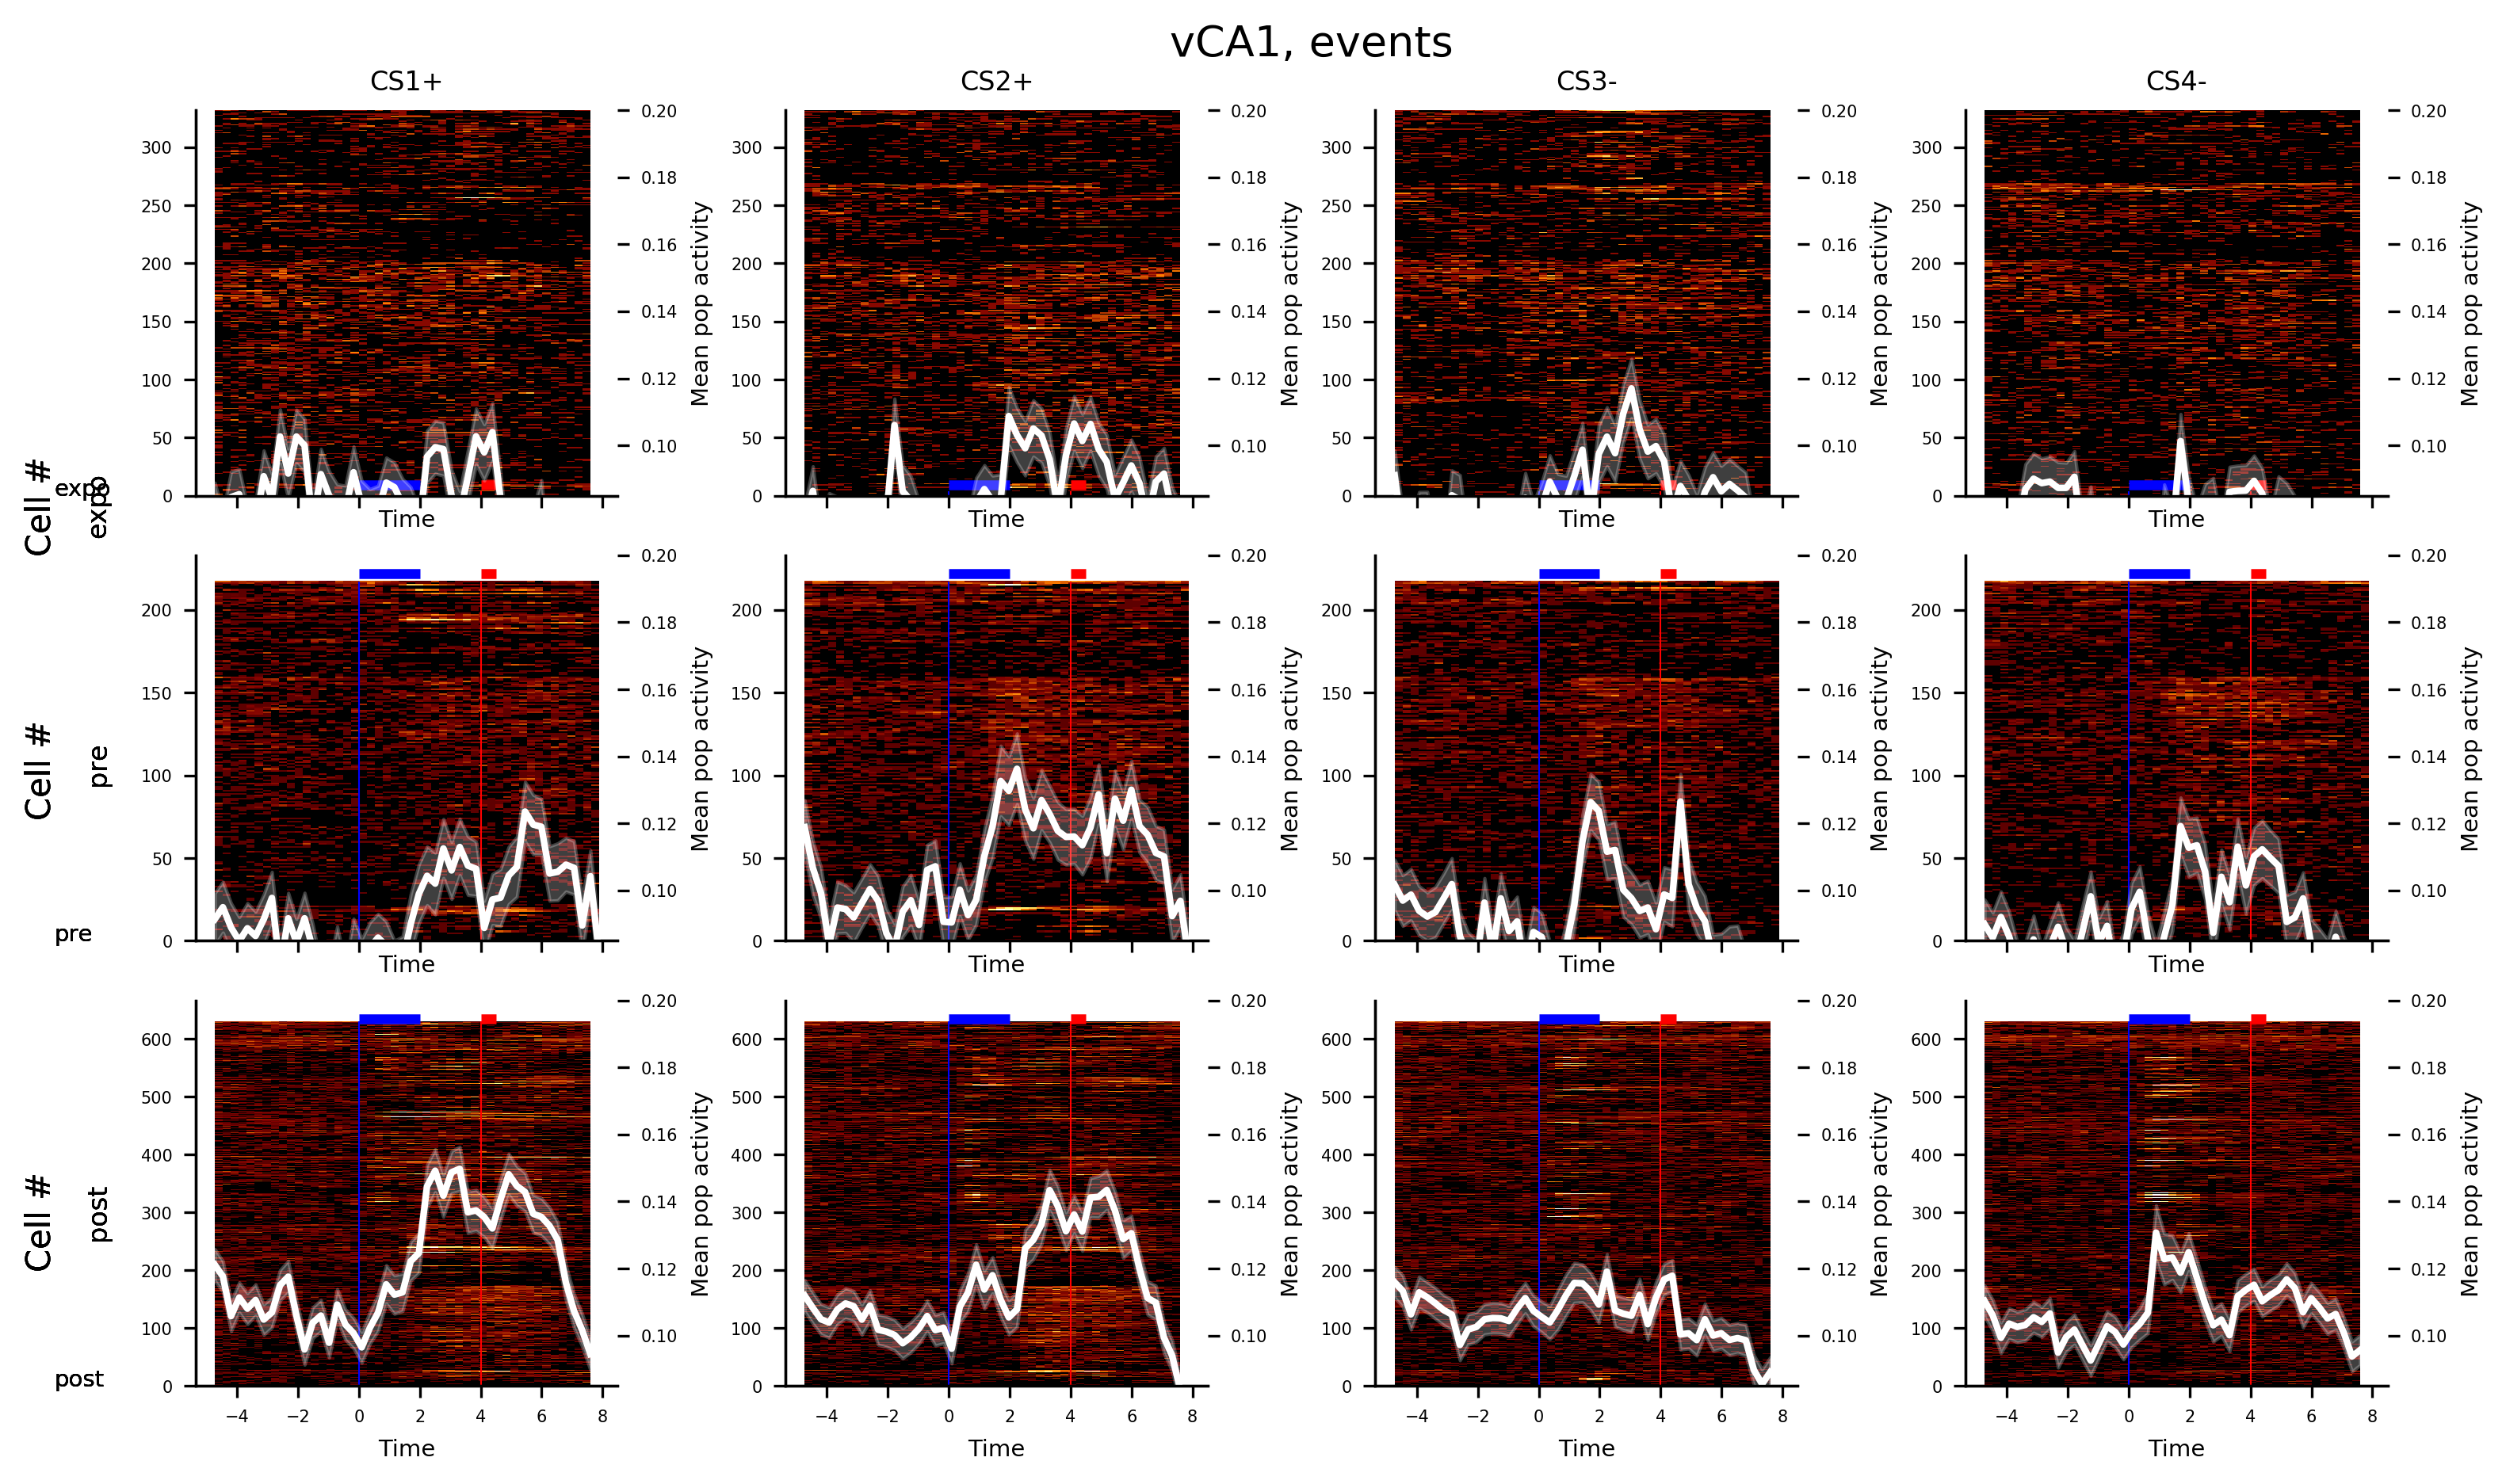

In [23]:
fig, axs = pl.subplots(len(sessions), 4, figsize=(10, np.ceil(all_hms_pre_STIM1_evs.shape[0]/40.)), sharex=True)
for sess,i in zip(sessions,range(len(sessions))):
    for tt,z in zip(['STIM1','STIM2','STIM3','STIM4'],range(4)):
        func = lambda x, y: x.imshow(y, aspect='auto', extent=(eval("min_time_ax_single_%s[0]"%sess), eval("min_time_ax_single_%s[-1]"%sess), 0, 
                                 len(eval("all_hms_%s_%s_evs"%(sess,tt)))),vmin=0, vmax=1, cmap='afmhot')

        func(axs[i][z], eval("all_hms_%s_%s_evs"%(sess,tt)))
        axs[i][0].text(-10,0, sess, fontsize=7)
        axs[i][z].set_xlabel("Time")
        axs[i][z].vlines([0, 4], 0, len(eval("all_hms_%s_CSm_evs"%sess)), color=['b','r'], lw=.5)
        axs[i][z].hlines(len(eval("all_hms_%s_CSm_evs"%sess))+5, 0, 2, color='b', lw=3)
        axs[i][z].hlines(len(eval("all_hms_%s_CSm_evs"%sess))+5, 4, 4.5, color='r', lw=3)
        axs[i][0].text(-9,len(eval("all_hms_%s_CSm_evs"%sess))/2, sess, fontsize=8, rotation=90)
        axs[i][0].text(-11,len(eval("all_hms_%s_CSm_evs"%sess))/2+10, "Cell #", fontsize=10, rotation=90)
        twin_ax = axs[i][z].twinx()
        twin_ax.set_ylabel("Mean pop activity")
        twin_ax.plot(eval("min_time_ax_single_%s"%sess),eval("all_hms_%s_%s_evs.mean(0)"%(sess,tt)),color='w',lw=2)
        m = eval("all_hms_%s_%s_evs.mean(0)"%(sess,tt))
        sem = eval("all_hms_%s_%s_evs.std(0)/(math.sqrt(len(all_hms_%s_%s_evs)))"%(sess,tt,sess,tt))
        twin_ax.fill_between(eval("min_time_ax_single_%s"%sess),m-sem,m+sem,alpha=0.25,color='w',linewidth=1)
        twin_ax.set_ylim(0.085,.2)

# axs[0][0].imshow(all_hms_pre1[sort_pre1], aspect='auto', extent=(time_ax_single[0], time_ax_single[-1], 0, len(sort_pre1)),
#                  vmin=0, vmax=1)
#for ax in axs.flatten():
#    #pt.remove_axes(ax)
#    ax.tick_params(
#    axis='x',          # changes apply to the x-axis
#    which='both',      # both major and minor ticks are affected
#    bottom=False,      # ticks along the bottom edge are off
#    top=False,         # ticks along the top edge are off
#    labelbottom=False) # labels along the bottom edge are off
    #ax.vlines([0, 4], 0, len(sort_pre_CSm), color='b', lw=.5)

axs[0][0].set_title('CS1+', fontsize=8)
axs[0][1].set_title('CS2+', fontsize=8)
axs[0][2].set_title('CS3-', fontsize=8)
axs[0][3].set_title('CS4-', fontsize=8)

fig.suptitle("vCA1, events", fontsize=13, y=1.02)
fig.tight_layout()
#fig.savefig('../img/%s_event_heatmaps.jpg'%(NOTEBOOK_NAME))

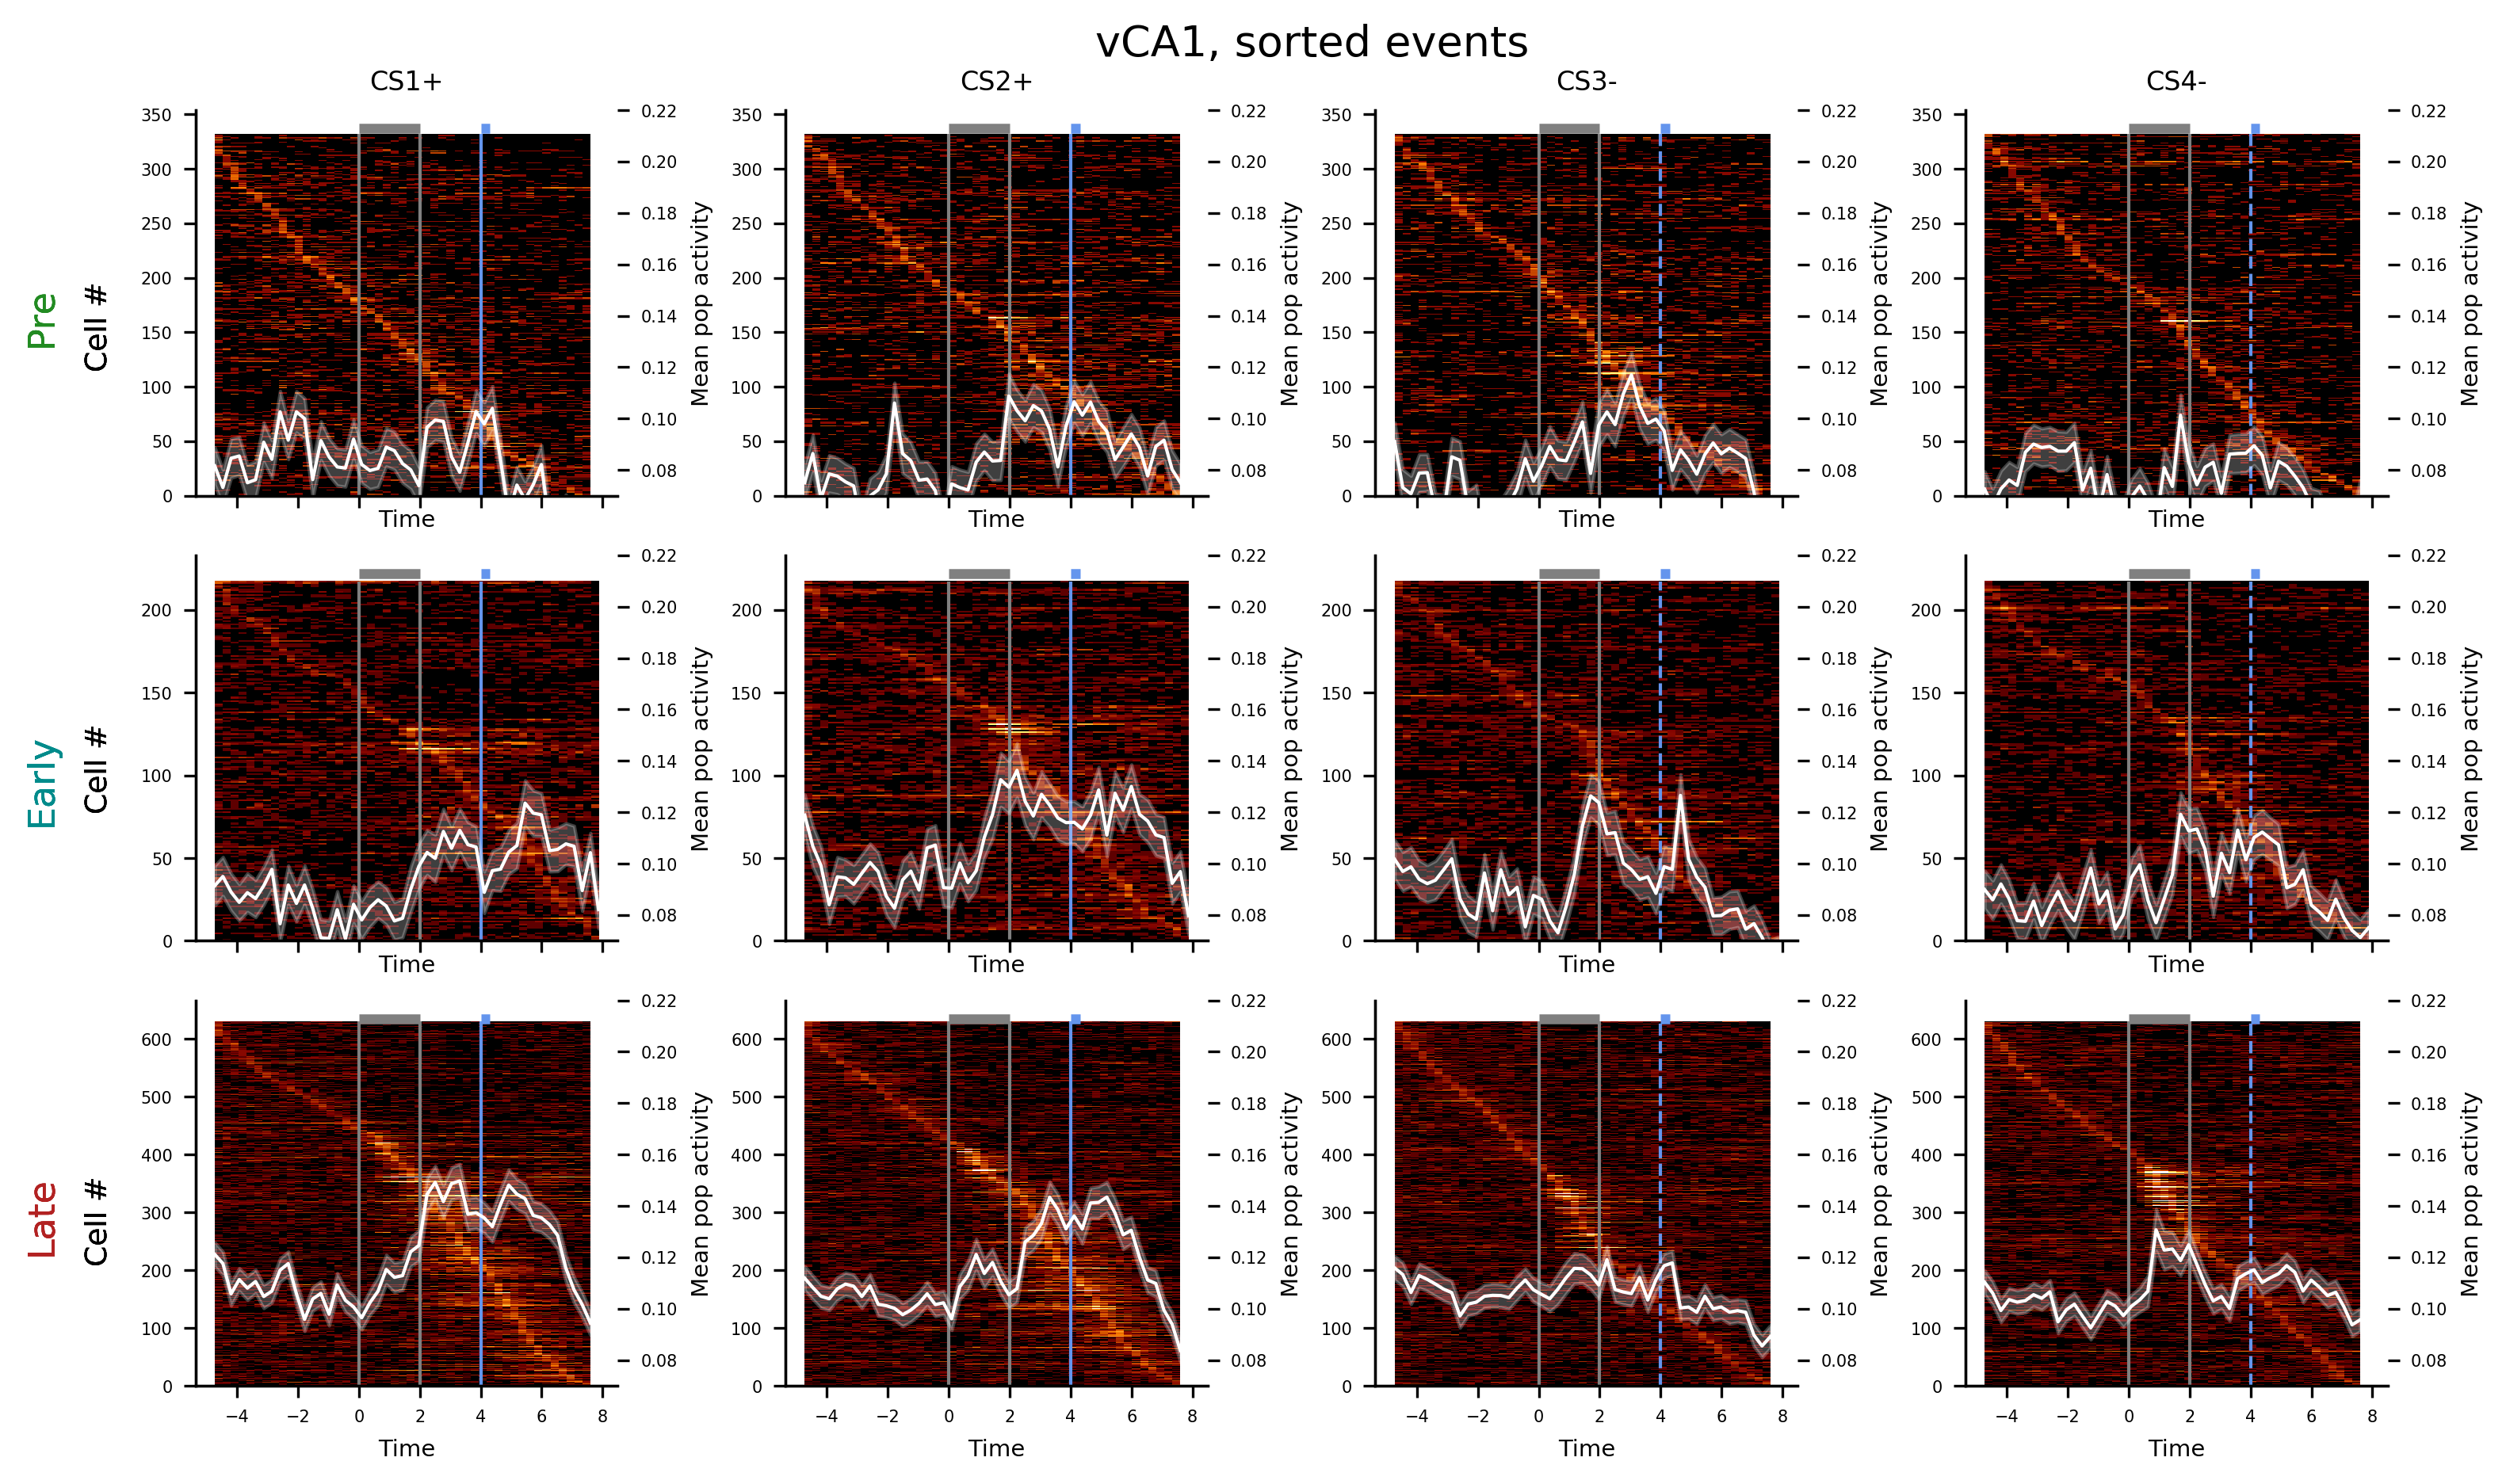

In [37]:
fig, axs = pl.subplots(len(sessions), 4, figsize=(10, np.ceil(all_hms_pre_STIM1_evs.shape[0]/40.)), sharex=True)
for sess,i,la,c in zip(sessions,range(len(sessions)),session_labels,dark_co):
    for tt,z in zip(['STIM1','STIM2','STIM3','STIM4'],range(4)):
        func = lambda x, y: x.imshow(y, aspect='auto', extent=(eval("min_time_ax_single_%s[0]"%sess), eval("min_time_ax_single_%s[-1]"%sess), 0, 
                                 len(eval("all_hms_%s_%s_evs"%(sess,tt)))),vmin=0, vmax=1, cmap='afmhot')

        func(axs[i][z], eval("all_hms_%s_%s_evs[sort_%s_%s_evs]"%(sess,tt,sess,tt)))
        #axs[i][0].text(-10,0, sess, fontsize=7)
        axs[i][z].set_xlabel("Time")
        axs[i][z].vlines([0, 2], 0, len(eval("all_hms_%s_STIM1_evs"%sess)), color=['grey','grey'], lw=1)
        if z < 2:
            axs[i][z].vlines([4], 0, len(eval("all_hms_%s_STIM1_evs"%sess)), color=['cornflowerblue'], lw=1)
        if z > 1:
            axs[i][z].vlines([4], 0, len(eval("all_hms_%s_STIM1_evs"%sess)), color=['cornflowerblue'], lw=1, linestyle='--')
        axs[i][z].hlines(len(eval("all_hms_%s_STIM1_evs"%sess))+5, 0, 2, color='grey', lw=3)
        axs[i][z].hlines(len(eval("all_hms_%s_STIM1_evs"%sess))+5, 4, 4.3, color='cornflowerblue', lw=3)
        axs[i][0].text(-11,len(eval("all_hms_%s_STIM1_evs"%sess))/2, la, fontsize=11, rotation=90, color=c)
        axs[i][0].text(-9,len(eval("all_hms_%s_STIM1_evs"%sess))/2+10, "Cell #", fontsize=9, rotation=90)
        twin_ax = axs[i][z].twinx()
        twin_ax.set_ylabel("Mean pop activity")
        twin_ax.plot(eval("min_time_ax_single_%s"%sess),eval("all_hms_%s_%s_evs.mean(0)"%(sess,tt)),color='w',lw=1)
        m = eval("all_hms_%s_%s_evs.mean(0)"%(sess,tt))
        sem = eval("all_hms_%s_%s_evs.std(0)/(math.sqrt(len(all_hms_%s_%s_evs)))"%(sess,tt,sess,tt))
        twin_ax.fill_between(eval("min_time_ax_single_%s"%sess),m-sem,m+sem,alpha=0.25,color='w',linewidth=1)
        twin_ax.set_ylim(0.07,.22)

# axs[0][0].imshow(all_hms_pre1[sort_pre1], aspect='auto', extent=(time_ax_single[0], time_ax_single[-1], 0, len(sort_pre1)),
#                  vmin=0, vmax=1)
#for ax in axs.flatten():
#    #pt.remove_axes(ax)
#    ax.tick_params(
#    axis='x',          # changes apply to the x-axis
#    which='both',      # both major and minor ticks are affected
#    bottom=False,      # ticks along the bottom edge are off
#    top=False,         # ticks along the top edge are off
#    labelbottom=False) # labels along the bottom edge are off
    #ax.vlines([0, 4], 0, len(sort_pre_STIM1), color='b', lw=.5)

axs[0][0].set_title('CS1+', fontsize=8)
axs[0][1].set_title('CS2+', fontsize=8)
axs[0][2].set_title('CS3-', fontsize=8)
axs[0][3].set_title('CS4-', fontsize=8)

fig.suptitle("vCA1, sorted events", fontsize=13, y=1.02)
fig.tight_layout()
fig.savefig('../figures/%s_sorted_event_heatmaps.pdf'%(NOTEBOOK_NAME))

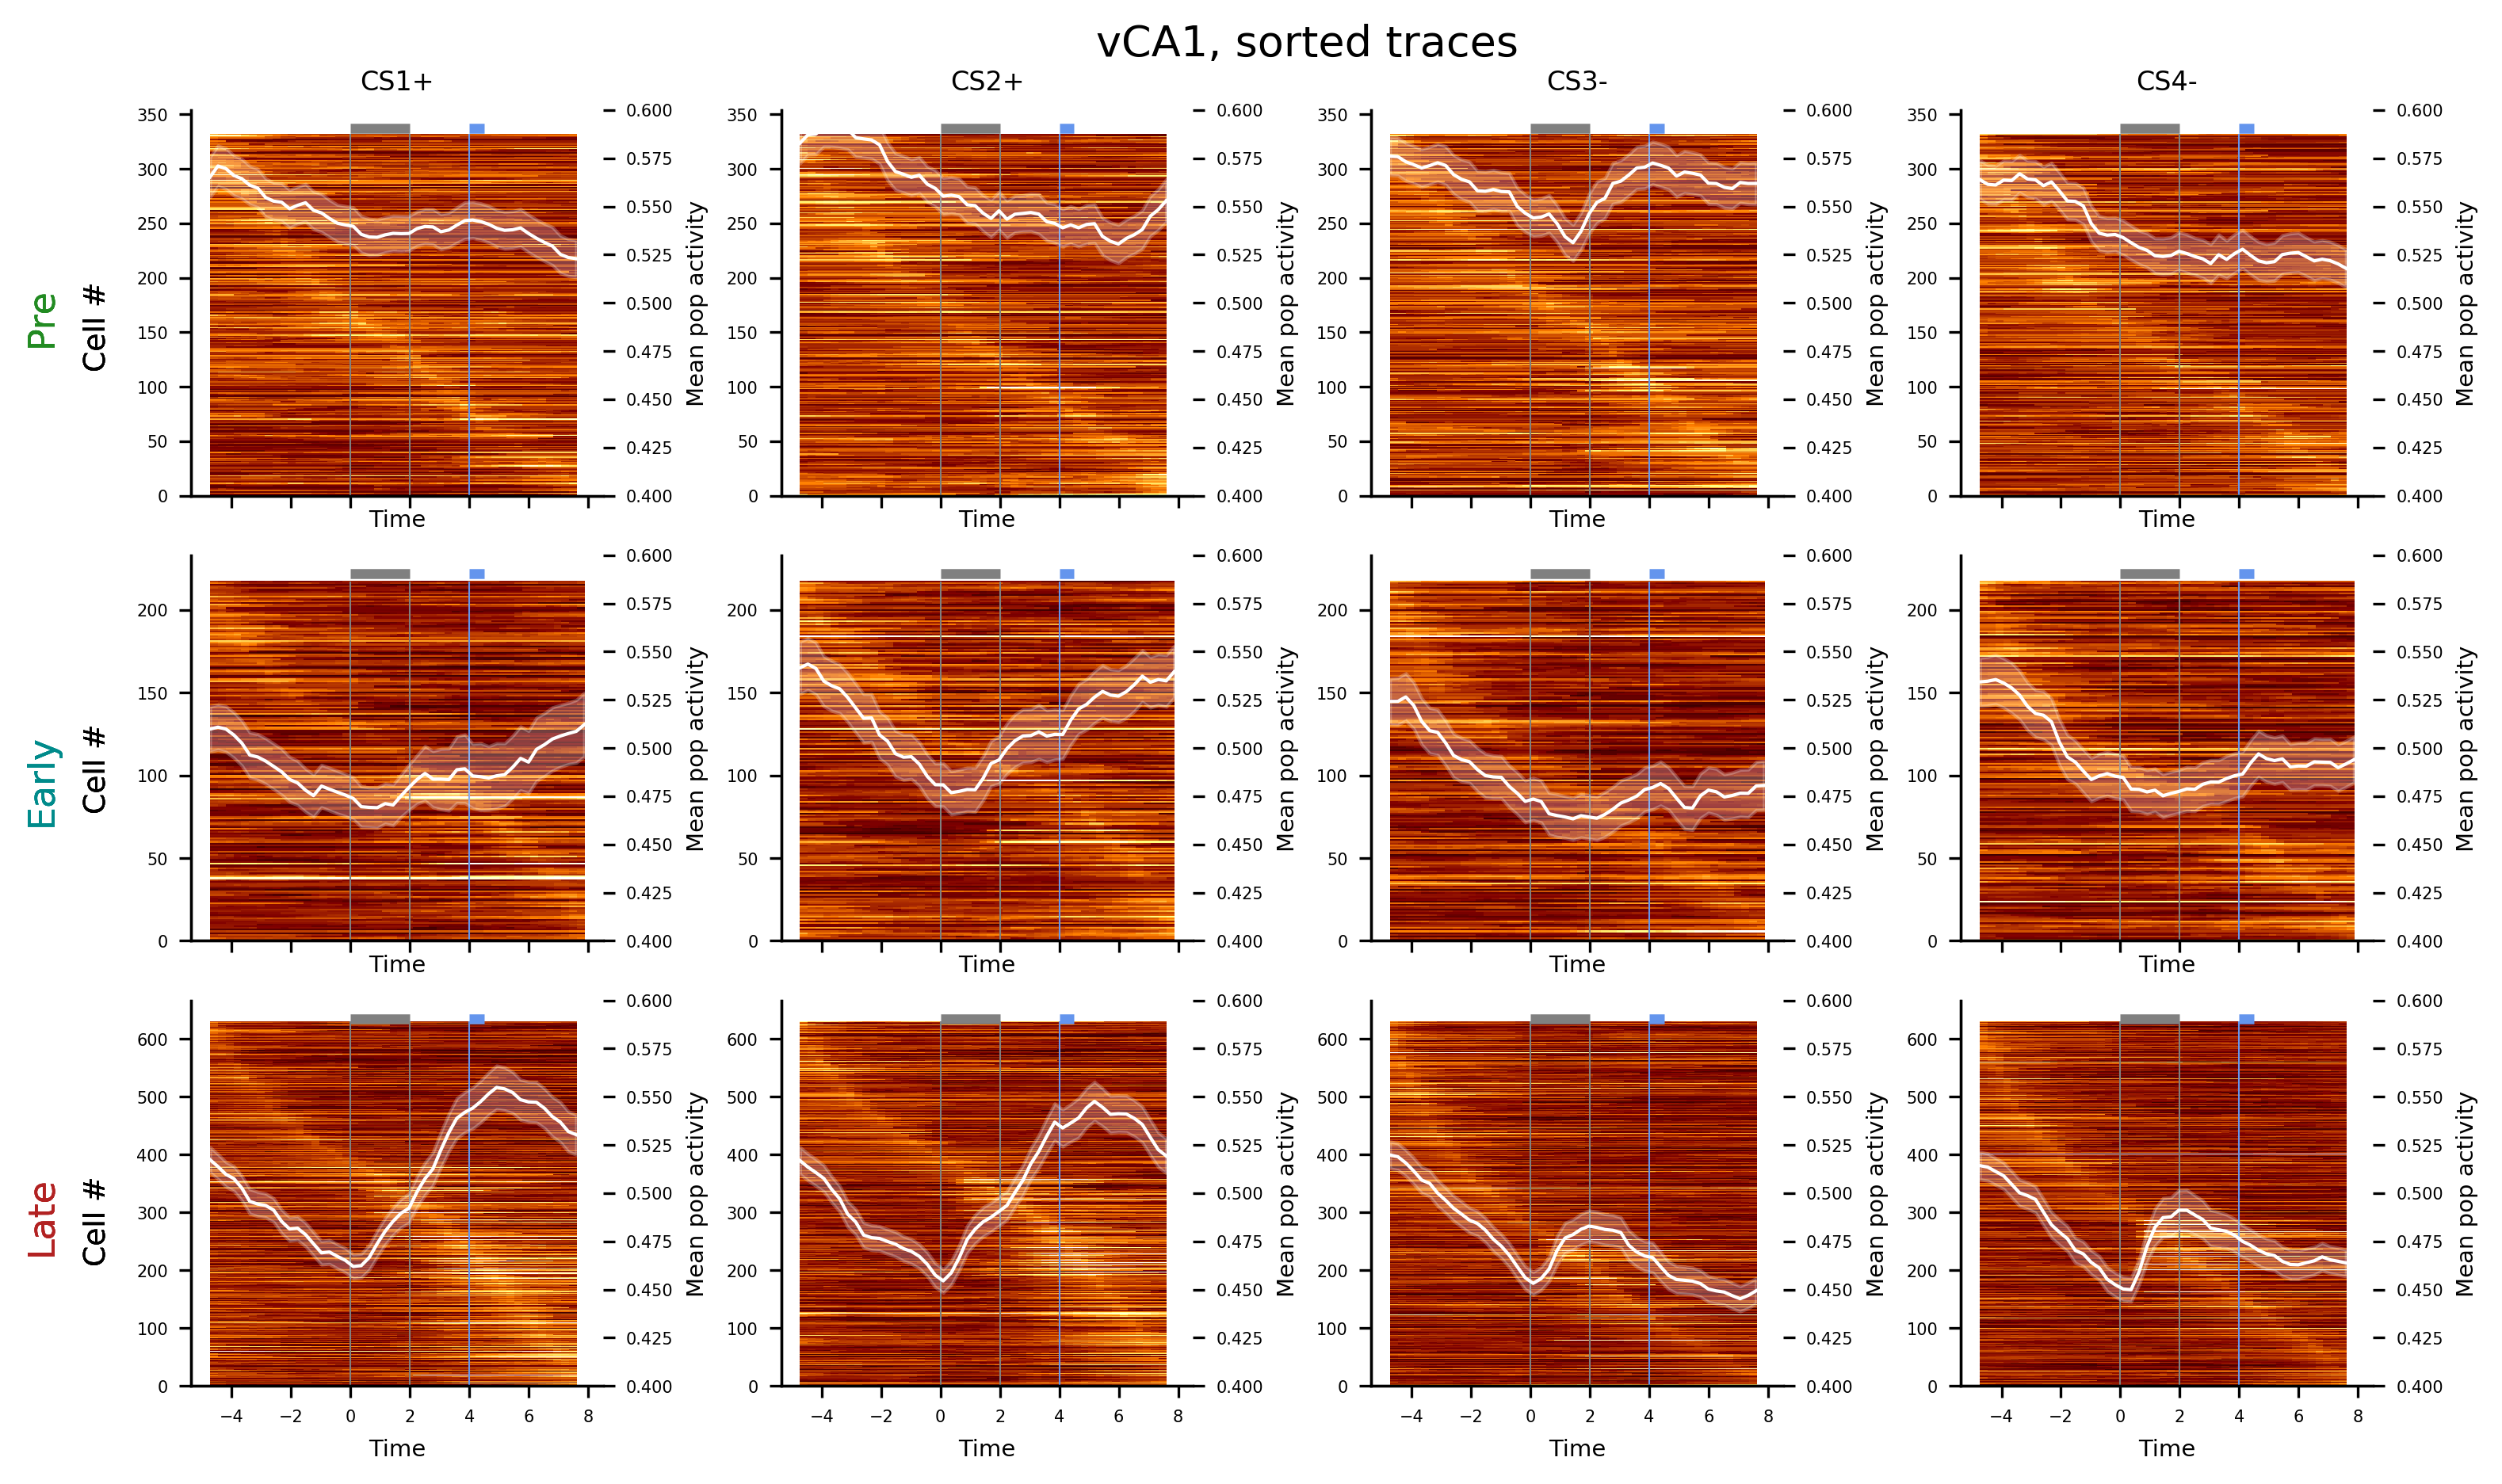

In [26]:
fig, axs = pl.subplots(len(sessions), 4, figsize=(10, np.ceil(all_hms_pre_STIM1_traces.shape[0]/40.)), sharex=True)
for sess,i,la,c in zip(sessions,range(len(sessions)),session_labels,dark_co):
    for tt,z in zip(['STIM1','STIM2','STIM3','STIM4'],range(4)):
        func = lambda x, y: x.imshow(y, aspect='auto', extent=(eval("min_time_ax_single_%s[0]"%sess), eval("min_time_ax_single_%s[-1]"%sess), 0, 
                                 len(eval("all_hms_%s_%s_traces"%(sess,tt)))),vmin=0, vmax=1.5, cmap='afmhot')

        func(axs[i][z], eval("all_hms_%s_%s_traces[sort_%s_%s_traces]"%(sess,tt,sess,tt)))
        #axs[i][0].text(-10,0, sess, fontsize=7)
        axs[i][z].set_xlabel("Time")
        axs[i][z].vlines([0, 2, 4], 0, len(eval("all_hms_%s_STIM1_traces"%sess)), color=['grey','grey','cornflowerblue'], lw=.5)
        axs[i][z].hlines(len(eval("all_hms_%s_STIM1_traces"%sess))+5, 0, 2, color='grey', lw=3)
        axs[i][z].hlines(len(eval("all_hms_%s_STIM1_traces"%sess))+5, 4, 4.5, color='cornflowerblue', lw=3)
        axs[i][0].text(-11,len(eval("all_hms_%s_STIM1_traces"%sess))/2, la, fontsize=11, rotation=90, color=c)
        axs[i][0].text(-9,len(eval("all_hms_%s_STIM1_traces"%sess))/2+10, "Cell #", fontsize=9, rotation=90)
        twin_ax = axs[i][z].twinx()
        twin_ax.set_ylabel("Mean pop activity")
        twin_ax.plot(eval("min_time_ax_single_%s"%sess),eval("all_hms_%s_%s_traces.mean(0)"%(sess,tt)),color='w',lw=1)
        m = eval("all_hms_%s_%s_traces.mean(0)"%(sess,tt))
        sem = eval("all_hms_%s_%s_traces.std(0)/(math.sqrt(len(all_hms_%s_%s_traces)))"%(sess,tt,sess,tt))
        twin_ax.fill_between(eval("min_time_ax_single_%s"%sess),m-sem,m+sem,alpha=0.25,color='w',linewidth=1)
        twin_ax.set_ylim(0.4,.6)

# axs[0][0].imshow(all_hms_pre1[sort_pre1], aspect='auto', extent=(time_ax_single[0], time_ax_single[-1], 0, len(sort_pre1)),
#                  vmin=0, vmax=1)
#for ax in axs.flatten():
#    #pt.remove_axes(ax)
#    ax.tick_params(
#    axis='x',          # changes apply to the x-axis
#    which='both',      # both major and minor ticks are affected
#    bottom=False,      # ticks along the bottom edge are off
#    top=False,         # ticks along the top edge are off
#    labelbottom=False) # labels along the bottom edge are off
    #ax.vlines([0, 4], 0, len(sort_pre_STIM1), color='b', lw=.5)

axs[0][0].set_title('CS1+', fontsize=8)
axs[0][1].set_title('CS2+', fontsize=8)
axs[0][2].set_title('CS3-', fontsize=8)
axs[0][3].set_title('CS4-', fontsize=8)

fig.suptitle("vCA1, sorted traces", fontsize=13, y=1.02)
fig.tight_layout()
fig.savefig('../figures/%s_sorted_traces_heatmaps.pdf'%(NOTEBOOK_NAME))

In [50]:
##this means nothing w/o cellReg cells
#from scipy import stats as sstats
#
#corrs_CSm = np.r_[[sstats.pearsonr(a1[:min(len(a1), len(a2))], a2[:min(len(a1), len(a2))])[0]
#                 for a1, a2 in zip(all_hms_pre_CSm[sort_pre_CSm], all_hms_post_CSm[sort_pre_CSm])]]
#corrs_Rew = np.r_[[sstats.pearsonr(a1[:min(len(a1), len(a2))], a2[:min(len(a1), len(a2))])[0]
#                 for a1, a2 in zip(all_hms_pre_Rew[sort_pre_Rew], all_hms_post_Rew[sort_pre_Rew])]]
#corrs_Sh = np.r_[[sstats.pearsonr(a1[:min(len(a1), len(a2))], a2[:min(len(a1), len(a2))])[0]
#                 for a1, a2 in zip(all_hms_pre_Sh[sort_pre_Sh], all_hms_post_Sh[sort_pre_Sh])]]
#
#fig, ax = pl.subplots(1, 1, figsize=(2, 1))
#pt.plot_bars([corrs_CSm, corrs_Rew, corrs_Sh], stderr=True, ax=ax)
#pt.add_significance(ax, corrs_CSm, corrs_Rew, 0, 1, 0.2, sig_func=lambda x, y: sstats.kendalltau(x, y))
#pt.nicer_plot(ax)
#ax.set_xticks(range(3))
#ax.set_xticklabels(['CS-', 'Rew', 'Shock'])
#ax.set_ylabel('Tuning correlation\nPRE vs POST')

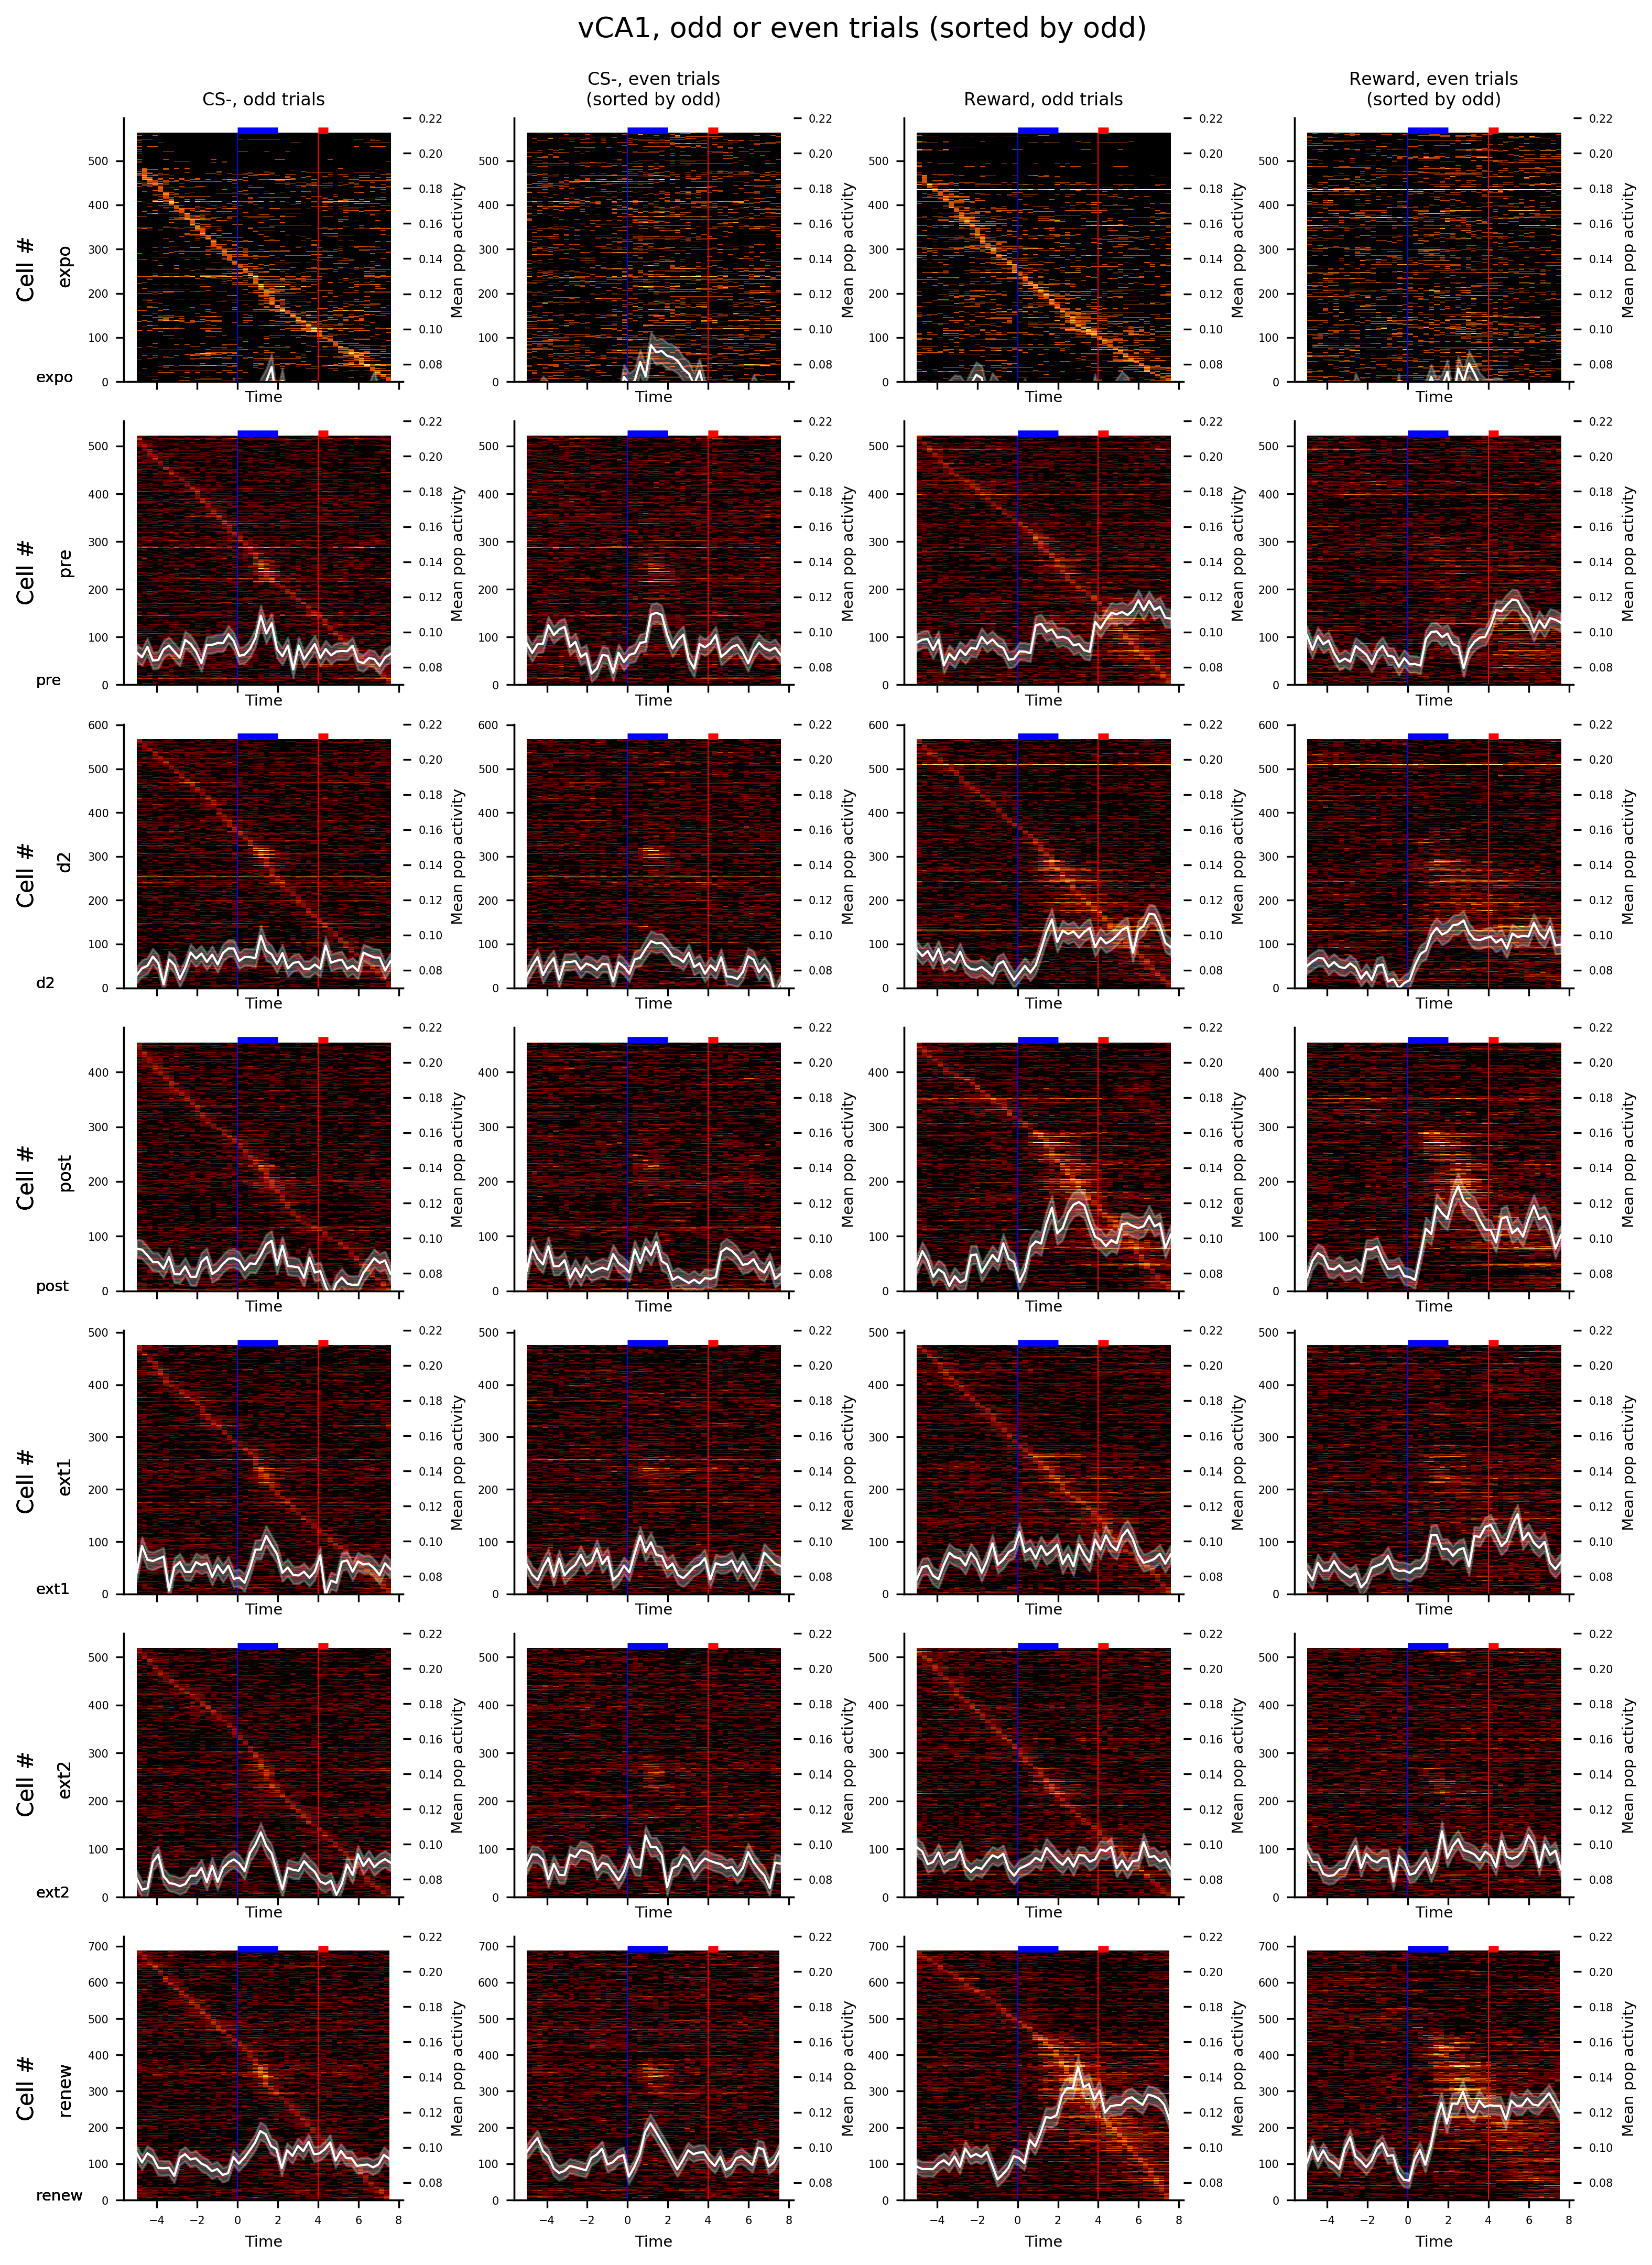

In [51]:
fig, axs = pl.subplots(len(sessions), 4, figsize=(10, np.ceil(all_hms_pre_CSm_evs.shape[0]/40.)), sharex=True)
for sess,i in zip(sessions,range(len(sessions))):
    for tt,eo,z in zip(['CSm','CSm','Rew','Rew'],['odd','even','odd','even'],range(4)):
        func = lambda x, y: x.imshow(y, aspect='auto', extent=(eval("min_time_ax_single_%s[0]"%sess), eval("min_time_ax_single_%s[-1]"%sess), 0, 
                                 len(eval("all_hms_%s_%s_evs"%(sess,tt)))),vmin=0, vmax=1, cmap='afmhot')

        func(axs[i][z], eval("all_hms_%s_%s_evs_%s[sort_%s_%s_evs_odd]"%(sess,tt,eo,sess,tt)))
        axs[i][0].text(-10,0, sess, fontsize=7)
        axs[i][z].set_xlabel("Time")
        axs[i][z].vlines([0, 4], 0, len(eval("all_hms_%s_CSm_evs"%sess)), color=['b','r'], lw=.5)
        axs[i][z].hlines(len(eval("all_hms_%s_CSm_evs"%sess))+5, 0, 2, color='b', lw=3)
        axs[i][z].hlines(len(eval("all_hms_%s_CSm_evs"%sess))+5, 4, 4.5, color='r', lw=3)
        axs[i][0].text(-9,len(eval("all_hms_%s_CSm_evs"%sess))/2, sess, fontsize=8, rotation=90)
        axs[i][0].text(-11,len(eval("all_hms_%s_CSm_evs"%sess))/2+10, "Cell #", fontsize=10, rotation=90)
        twin_ax = axs[i][z].twinx()
        twin_ax.set_ylabel("Mean pop activity")
        twin_ax.plot(eval("min_time_ax_single_%s"%sess),eval("all_hms_%s_%s_evs_%s.mean(0)"%(sess,tt,eo)),color='w',lw=1)
        m = eval("all_hms_%s_%s_evs_%s.mean(0)"%(sess,tt,eo))
        sem = eval("all_hms_%s_%s_evs_%s.std(0)/(math.sqrt(len(all_hms_%s_%s_evs_%s)))"%(sess,tt,eo,sess,tt,eo))
        twin_ax.fill_between(eval("min_time_ax_single_%s"%sess),m-sem,m+sem,alpha=0.25,color='w',linewidth=1)
        twin_ax.set_ylim(0.07,.22)

# axs[0][0].imshow(all_hms_pre1[sort_pre1], aspect='auto', extent=(time_ax_single[0], time_ax_single[-1], 0, len(sort_pre1)),
#                  vmin=0, vmax=1)
#for ax in axs.flatten():
#    #pt.remove_axes(ax)
#    ax.tick_params(
#    axis='x',          # changes apply to the x-axis
#    which='both',      # both major and minor ticks are affected
#    bottom=False,      # ticks along the bottom edge are off
#    top=False,         # ticks along the top edge are off
#    labelbottom=False) # labels along the bottom edge are off
    #ax.vlines([0, 4], 0, len(sort_pre_CSm), color='b', lw=.5)

axs[0][0].set_title('CS-, odd trials', fontsize=8)
axs[0][1].set_title('CS-, even trials\n(sorted by odd)', fontsize=8)
axs[0][2].set_title('Reward, odd trials', fontsize=8)
axs[0][3].set_title('Reward, even trials\n(sorted by odd)', fontsize=8)

fig.suptitle("vCA1, odd or even trials (sorted by odd)", fontsize=13, y=1.02)
fig.tight_layout()
fig.savefig('../final-ish figures/%s_sorted_event_heatmaps_EO.pdf'%(NOTEBOOK_NAME))

# 3rd method for assessing activation width (via Vijay)

def filter_cycle_JSB(time_ax, cycles, cycle):
    return (time_ax>=cycles[cycle][0]-2.5) * (time_ax<cycles[cycle][1]+3) #since cycles start -5 and end at +8, but imaged from
#-8 to +11ish, can take up to 3 seconds pre to cycle onset and 3 post offset

def compute_all_dffs_JSB(time_ax, dff, cell, cycles, cycle_filter=lambda x: True):
    return np.r_[[dff[:, cell][filter_cycle_JSB(time_ax, cycles, cycle)][:68] #emprically found that 68 seems to be min # of time bins
                              for cycle in range(len(cycles)) if cycle_filter(cycle)]]

#zscored = True

for sess in sessions:
    exec("all_hms_%s_CSm_evs_JSB=[]"%sess)
    exec("all_hms_%s_Rew_evs_JSB=[]"%sess)
    for animal in eval("%s_animals"%sess):
    #    cellregs = anivars[animal]['cellregs']
        exec("vars_%s = %s_anivars['%s']['vars_%s']"%(sess,sess,animal,sess))
    
        for k in eval("vars_%s.keys()"%sess):
            exec('%s = vars_%s[\'%s\']' % (k,sess,k))
    
        exec("hm_%s_CSm_evs_JSB = np.r_[[compute_all_dffs_JSB(time_ax, events, cell, cycles[is_CSmt])\
                        for cell in range(len(vars_%s['events'][0]))]]"%(sess,sess))
        #exec("hm_%s_CSm_evs_JSB = np.r_[[np.mean(h, 0)/np.std(h, 0) if zscored else np.mean(h, 0)/np.max(h.mean(0)) for h in hm_%s_CSm_evs_JSB]]"%(sess,sess))
        exec("hm_%s_CSm_evs_JSB = np.r_[[np.mean(h, 0) for h in hm_%s_CSm_evs_JSB]]"%(sess,sess))
        exec("hm_%s_Rew_evs_JSB = np.r_[[compute_all_dffs_JSB(time_ax, events, cell, cycles[is_rewardt])\
                        for cell in range(len(vars_%s['events'][0]))]]"%(sess,sess))
        #exec("hm_%s_Rew_evs_JSB = np.r_[[np.mean(h, 0)/np.std(h, 0) if zscored else np.mean(h, 0)/np.max(h.mean(0)) for h in hm_%s_Rew_evs_JSB]]"%(sess,sess))
        exec("hm_%s_Rew_evs_JSB = np.r_[[np.mean(h, 0) for h in hm_%s_Rew_evs_JSB]]"%(sess,sess))
        print len(eval("hm_%s_Rew_evs_JSB[0]"%(sess))),

        eval("all_hms_%s_CSm_evs_JSB.append(hm_%s_CSm_evs_JSB)"%(sess, sess))
        eval("all_hms_%s_Rew_evs_JSB.append(hm_%s_Rew_evs_JSB)"%(sess, sess))

#zscored = True

for sess in sessions:
    exec("all_hms_%s_CSm_traces_JSB=[]"%sess)
    exec("all_hms_%s_Rew_traces_JSB=[]"%sess)
    for animal in eval("%s_animals"%sess):
    #    cellregs = anivars[animal]['cellregs']
        exec("vars_%s = %s_anivars['%s']['vars_%s']"%(sess,sess,animal,sess))
    
        for k in eval("vars_%s.keys()"%sess):
            exec('%s = vars_%s[\'%s\']' % (k,sess,k))
    
        exec("hm_%s_CSm_traces = np.r_[[compute_all_dffs_JSB(time_ax, traces, cell, cycles[is_CSmt])\
                        for cell in range(len(vars_%s['traces'][0]))]]"%(sess,sess))
        #exec("hm_%s_CSm_traces = np.r_[[np.mean(h, 0)/np.std(h, 0) if zscored else np.mean(h, 0)/np.max(h.mean(0)) for h in hm_%s_CSm_traces]]"%(sess,sess))
        exec("hm_%s_CSm_traces = np.r_[[np.mean(h, 0) for h in hm_%s_CSm_traces]]"%(sess,sess))
        exec("hm_%s_Rew_traces = np.r_[[compute_all_dffs_JSB(time_ax, traces, cell, cycles[is_rewardt])\
                        for cell in range(len(vars_%s['traces'][0]))]]"%(sess,sess))
        #exec("hm_%s_Rew_traces = np.r_[[np.mean(h, 0)/np.std(h, 0) if zscored else np.mean(h, 0)/np.max(h.mean(0)) for h in hm_%s_Rew_traces]]"%(sess,sess))
        exec("hm_%s_Rew_traces = np.r_[[np.mean(h, 0) for h in hm_%s_Rew_traces]]"%(sess,sess))
        print len(eval("hm_%s_Rew_traces[0]"%(sess))),
        eval("all_hms_%s_CSm_traces_JSB.append(hm_%s_CSm_traces)"%(sess, sess))
        eval("all_hms_%s_Rew_traces_JSB.append(hm_%s_Rew_traces)"%(sess, sess))

#zscored = True

for sess in sessions:
    exec("all_hms_%s_CSm_evs_even_JSB=[]"%sess)
    exec("all_hms_%s_Rew_evs_even_JSB=[]"%sess)
    exec("all_hms_%s_CSm_evs_odd_JSB=[]"%sess)
    exec("all_hms_%s_Rew_evs_odd_JSB=[]"%sess)
    for animal in eval("%s_animals"%sess):
    #    cellregs = anivars[animal]['cellregs']
        exec("vars_%s = %s_anivars['%s']['vars_%s']"%(sess,sess,animal,sess))
    
        for k in eval("vars_%s.keys()"%sess):
            exec('%s = vars_%s[\'%s\']' % (k,sess,k))
        
        for eo in 'even','odd':
            exec("hm_%s_CSm_evs_JSB = np.r_[[compute_all_dffs_JSB(time_ax, events, cell, cycles[is_CSmt_%s_%s_%s])\
                            for cell in range(len(vars_%s['events'][0]))]]"%(sess,eo,sess,animal,sess))
            #exec("hm_%s_CSm_evs_JSB = np.r_[[np.mean(h, 0)/np.std(h, 0) if zscored else np.mean(h, 0)/np.max(h.mean(0)) for h in hm_%s_CSm_evs_JSB]]"%(sess,sess))
            exec("hm_%s_CSm_evs_JSB = np.r_[[np.mean(h, 0) for h in hm_%s_CSm_evs_JSB]]"%(sess,sess))
            exec("hm_%s_Rew_evs_JSB = np.r_[[compute_all_dffs_JSB(time_ax, events, cell, cycles[is_rewardt_%s_%s_%s])\
                            for cell in range(len(vars_%s['events'][0]))]]"%(sess,eo,sess,animal,sess))
            #exec("hm_%s_Rew_evs_JSB = np.r_[[np.mean(h, 0)/np.std(h, 0) if zscored else np.mean(h, 0)/np.max(h.mean(0)) for h in hm_%s_Rew_evs_JSB]]"%(sess,sess))
            exec("hm_%s_Rew_evs_JSB = np.r_[[np.mean(h, 0) for h in hm_%s_Rew_evs_JSB]]"%(sess,sess))
            print len(eval("hm_%s_Rew_evs_JSB[0]"%(sess))),

            eval("all_hms_%s_CSm_evs_%s_JSB.append(hm_%s_CSm_evs_JSB)"%(sess,eo,sess))
            eval("all_hms_%s_Rew_evs_%s_JSB.append(hm_%s_Rew_evs_JSB)"%(sess,eo,sess))

#zscored = True

for sess in sessions:
    exec("all_hms_%s_CSm_traces_even_JSB=[]"%sess)
    exec("all_hms_%s_Rew_traces_even_JSB=[]"%sess)
    exec("all_hms_%s_CSm_traces_odd_JSB=[]"%sess)
    exec("all_hms_%s_Rew_traces_odd_JSB=[]"%sess)
    for animal in eval("%s_animals"%sess):
    #    cellregs = anivars[animal]['cellregs']
        exec("vars_%s = %s_anivars['%s']['vars_%s']"%(sess,sess,animal,sess))
    
        for k in eval("vars_%s.keys()"%sess):
            exec('%s = vars_%s[\'%s\']' % (k,sess,k))
    
        for eo in 'even','odd':
            exec("hm_%s_CSm_traces = np.r_[[compute_all_dffs_JSB(time_ax, traces, cell, cycles[is_CSmt_%s_%s_%s])\
                            for cell in range(len(vars_%s['traces'][0]))]]"%(sess,eo,sess,animal,sess))
            #exec("hm_%s_CSm_traces = np.r_[[np.mean(h, 0)/np.std(h, 0) if zscored else np.mean(h, 0)/np.max(h.mean(0)) for h in hm_%s_CSm_traces]]"%(sess,sess))
            exec("hm_%s_CSm_traces = np.r_[[np.mean(h, 0) for h in hm_%s_CSm_traces]]"%(sess,sess))
            exec("hm_%s_Rew_traces = np.r_[[compute_all_dffs_JSB(time_ax, traces, cell, cycles[is_rewardt_%s_%s_%s])\
                            for cell in range(len(vars_%s['traces'][0]))]]"%(sess,eo,sess,animal,sess))
            #exec("hm_%s_Rew_traces = np.r_[[np.mean(h, 0)/np.std(h, 0) if zscored else np.mean(h, 0)/np.max(h.mean(0)) for h in hm_%s_Rew_traces]]"%(sess,sess))
            exec("hm_%s_Rew_traces = np.r_[[np.mean(h, 0) for h in hm_%s_Rew_traces]]"%(sess,sess))
            print len(eval("hm_%s_Rew_traces[0]"%(sess))),
            
            eval("all_hms_%s_CSm_traces_%s_JSB.append(hm_%s_CSm_traces)"%(sess,eo,sess))
            eval("all_hms_%s_Rew_traces_%s_JSB.append(hm_%s_Rew_traces)"%(sess,eo,sess))

for sess in sessions:
    for trialtype in ('CSm','Rew'):
        exec("max_t_JSB = np.min([a.shape[1] for a in all_hms_%s_%s_traces_JSB])"%(sess,trialtype))
        exec("all_hms_%s_%s_evs_JSB = np.row_stack([a[:, :max_t_JSB] for a in all_hms_%s_%s_evs_JSB])"%(sess,trialtype,sess,trialtype))
        exec("all_hms_%s_%s_traces_JSB = np.row_stack([a[:, :max_t_JSB] for a in all_hms_%s_%s_traces_JSB])"%(sess,trialtype,sess,trialtype))
        #exec("min_time_ax_single_%s_JSB = (vars_%s['time_ax_single']+9)[:max_t_JSB]"%(sess,sess))
        for eo in 'even','odd':
            exec("all_hms_%s_%s_evs_%s_JSB = np.row_stack([a[:, :max_t_JSB] for a in all_hms_%s_%s_evs_%s_JSB])"%(sess,trialtype,eo,sess,trialtype,eo))
            exec("all_hms_%s_%s_traces_%s_JSB = np.row_stack([a[:, :max_t_JSB] for a in all_hms_%s_%s_traces_%s_JSB])"%(sess,trialtype,eo,sess,trialtype,eo))
    print max_t_JSB

#convert nan to 0
for sess in sessions:
    for tt in ('CSm','Rew'):
        exec("all_hms_%s_%s_evs_JSB[np.isnan(all_hms_%s_%s_evs_JSB)]=0"%(sess,tt,sess,tt))
        exec("all_hms_%s_%s_traces_JSB[np.isnan(all_hms_%s_%s_traces_JSB)]=0"%(sess,tt,sess,tt))

for sess in sessions:
    for trialtype in ('CSm','Rew'):
        exec("sort_%s_%s_evs_JSB = np.argsort([np.argmax(h) for h in all_hms_%s_%s_evs_JSB])"%(sess,trialtype,sess,trialtype))
        exec("minsort_%s_%s_evs_JSB = np.argsort([np.argmin(h) for h in all_hms_%s_%s_evs_JSB])"%(sess,trialtype,sess,trialtype))
        exec("sort_%s_%s_traces_JSB = np.argsort([np.argmax(h) for h in all_hms_%s_%s_traces_JSB])"%(sess,trialtype,sess,trialtype))
        exec("minsort_%s_%s_traces_JSB = np.argsort([np.argmin(h) for h in all_hms_%s_%s_traces_JSB])"%(sess,trialtype,sess,trialtype))

#convert nan to 0
for sess in sessions:
    for tt in ('CSm','Rew'):
        for trl in ('even','odd'):
            exec("all_hms_%s_%s_evs_%s_JSB[np.isnan(all_hms_%s_%s_evs_%s_JSB)]=0"%(sess,tt,trl,sess,tt,trl))
            exec("all_hms_%s_%s_traces_%s_JSB[np.isnan(all_hms_%s_%s_traces_%s_JSB)]=0"%(sess,tt,trl,sess,tt,trl))

for sess in sessions:
    for trialtype in ('CSm','Rew'):
        exec("sort_%s_%s_evs_even_JSB = np.argsort([np.argmax(h) for h in all_hms_%s_%s_evs_even_JSB])"%(sess,trialtype,sess,trialtype))
        exec("sort_%s_%s_traces_even_JSB = np.argsort([np.argmax(h) for h in all_hms_%s_%s_traces_even_JSB])"%(sess,trialtype,sess,trialtype))
        exec("sort_%s_%s_evs_odd_JSB = np.argsort([np.argmax(h) for h in all_hms_%s_%s_evs_odd_JSB])"%(sess,trialtype,sess,trialtype))
        exec("sort_%s_%s_traces_odd_JSB = np.argsort([np.argmax(h) for h in all_hms_%s_%s_traces_odd_JSB])"%(sess,trialtype,sess,trialtype))

pre_tbs=15 #how many time bins to examine prior to peak?
post_tbs=15
for sess in sessions:
    for tt in 'CSm','Rew':
        for signal in 'evs','traces':
            exec("odd_peak_even_PETH_%s_%s_%s = []"%(sess,tt,signal))
            for cell,i in zip(eval("all_hms_%s_%s_%s_odd_JSB"%(sess,tt,signal)), range(len(eval("all_hms_%s_%s_%s_odd_JSB"%(sess,tt,signal))))):
                x = np.where(cell == np.max(cell))
                ## exclue peaks that do not have enough time bins to collect
                if x[0][0]>=pre_tbs:
                    if x[0][0] < 68-post_tbs: #68 = total number of time bins
                        #print x[0][0],
                        exec("odd_peak_even_PETH_%s_%s_%s.append(all_hms_%s_%s_%s_even_JSB[i][x[0][0]-pre_tbs:x[0][0]+post_tbs+1])"%(sess,tt,signal,sess,tt,signal))

#next break up into where max is during baseline (tb 31 or before) or during odor-trace period (roughly).
pre_tbs=15 #how many time bins to examine prior to peak?
post_tbs=15
for sess in sessions:
    for tt in 'CSm','Rew':
        for signal in 'evs','traces':
            exec("odd_peak_even_PETH_%s_%s_%s_baseline = []"%(sess,tt,signal))
            exec("odd_peak_even_PETH_%s_%s_%s_trial = []"%(sess,tt,signal))
            for cell,i in zip(eval("all_hms_%s_%s_%s_odd_JSB"%(sess,tt,signal)), range(len(eval("all_hms_%s_%s_%s_odd_JSB"%(sess,tt,signal))))):
                x = np.where(cell == np.max(cell))
                ## exclue peaks that do not have enough time bins to collect
                if x[0][0]>=pre_tbs:
                    if x[0][0] < 68-post_tbs: #68 = total number of time bins
                        #print x[0][0],
                        if x[0][0]<31:
                            #normalize even amplitude wrt peak odd amplitude
                            exec("odd_peak_even_PETH_%s_%s_%s_baseline.append(all_hms_%s_%s_%s_even_JSB[i][x[0][0]-pre_tbs:x[0][0]+post_tbs+1])"%(sess,tt,signal,sess,tt,signal))
                        if x[0][0]>34:
                            if x[0][0]<50:
                                exec("odd_peak_even_PETH_%s_%s_%s_trial.append(all_hms_%s_%s_%s_even_JSB[i][x[0][0]-pre_tbs:x[0][0]+post_tbs+1])"%(sess,tt,signal,sess,tt,signal))

#next break up into where max is during baseline (tb 31 or before) or during odor-trace period (roughly).
#NORMALIZE EVEN ACTIVITY TO PEAK ODD ACTIVITY
pre_tbs=15 #how many time bins to examine prior to peak?
post_tbs=15
for sess in sessions:
    for tt in 'CSm','Rew':
        for signal in 'evs','traces':
            exec("odd_peak_even_PETH_%s_%s_%s_baseline_normed = []"%(sess,tt,signal))
            exec("odd_peak_even_PETH_%s_%s_%s_trial_normed = []"%(sess,tt,signal))
            for cell,i in zip(eval("all_hms_%s_%s_%s_odd_JSB"%(sess,tt,signal)), range(len(eval("all_hms_%s_%s_%s_odd_JSB"%(sess,tt,signal))))):
                x = np.where(cell == np.max(cell))
                ## exclue peaks that do not have enough time bins to collect
                if x[0][0]>=pre_tbs:
                    if x[0][0] < 68-post_tbs: #68 = total number of time bins
                        #print x[0][0],
                        if x[0][0]<31:
                            #normalize even amplitude wrt peak odd amplitude
                            exec("odd_peak_even_PETH_%s_%s_%s_baseline_normed.append(all_hms_%s_%s_%s_even_JSB[i][x[0][0]-pre_tbs:x[0][0]+post_tbs+1]\
                                  /cell[x])"%(sess,tt,signal,sess,tt,signal))
                        if x[0][0]>34:
                            if x[0][0]<50:
                                exec("odd_peak_even_PETH_%s_%s_%s_trial_normed.append(all_hms_%s_%s_%s_even_JSB[i][x[0][0]-pre_tbs:x[0][0]+post_tbs+1]\
                                      /cell[x])"%(sess,tt,signal,sess,tt,signal))

Xs = list(np.linspace(-4,4,31))
fig, axs = pl.subplots(len(sessions), 4, figsize=(11, np.ceil(all_hms_pre_CSm_evs.shape[0]/40.)), sharex=True)
for tt,eo,z in zip(['CSm','CSm','Rew','Rew'],['baseline','trial','baseline','trial'],range(4)):
    for sess,i in zip(sessions,range(len(sessions))):
        func = lambda x, y: x.imshow(y, aspect='auto', extent=(-4, 4, 0, len(eval("all_hms_%s_%s_evs"%(sess,tt)))),
                                     vmin=0, vmax=1.5, cmap='afmhot')

        func(axs[i][z], eval("odd_peak_even_PETH_%s_%s_evs_%s"%(sess,tt,eo)))
        axs[i][0].text(-6,0, sess, fontsize=7)
        axs[i][z].set_xlabel("Time")
        #axs[i][0].text(-9,len(eval("odd_peak_even_PETH_%s_%s_evs_%s"%(sess,tt,eo)))/2, sess, fontsize=8, rotation=90)
        axs[i][0].text(-8,200, "Cell #", fontsize=10, rotation=90)
        twin_ax = axs[i][z].twinx()
        twin_ax.set_ylabel("Mean pop activity")
        m = list(np.mean(eval("odd_peak_even_PETH_%s_%s_evs_%s"%(sess,tt,eo)),0))
        sem = np.std(eval("odd_peak_even_PETH_%s_%s_evs_%s"%(sess,tt,eo)),0)/(math.sqrt(len(eval("odd_peak_even_PETH_%s_%s_evs_%s"%(sess,tt,eo)))))
        twin_ax.fill_between(Xs,m-sem,m+sem,alpha=0.4,color='w',linewidth=1)
        #twin_ax.plot(Xs,m,color='w',lw=2)
        twin_ax.set_ylim(0.,1)

# axs[0][0].imshow(all_hms_pre1[sort_pre1], aspect='auto', extent=(time_ax_single[0], time_ax_single[-1], 0, len(sort_pre1)),
#                  vmin=0, vmax=1)
#for ax in axs.flatten():
#    #pt.remove_axes(ax)
#    ax.tick_params(
#    axis='x',          # changes apply to the x-axis
#    which='both',      # both major and minor ticks are affected
#    bottom=False,      # ticks along the bottom edge are off
#    top=False,         # ticks along the top edge are off
#    labelbottom=False) # labels along the bottom edge are off
    #ax.vlines([0, 4], 0, len(sort_pre_CSm), color='b', lw=.5)

axs[0][0].set_title('CS-, pre odor onset', fontsize=8)
axs[0][1].set_title('CS-, post odor onset', fontsize=8)
axs[0][2].set_title('CS+, pre odor onset', fontsize=8)
axs[0][3].set_title('CS+, post odor onset', fontsize=8)

fig.suptitle("vCA1, events", fontsize=13, y=1.02)
fig.tight_layout()
#fig.savefig('../img/%s_evs_heatmaps.jpg'%(NOTEBOOK_NAME))

Xs = list(np.linspace(-4,4,31))
fig, axs = pl.subplots(len(sessions), 4, figsize=(11, np.ceil(all_hms_pre_CSm_evs.shape[0]/40.)), sharex=True)
for tt,eo,z in zip(['CSm','CSm','Rew','Rew'],['baseline','trial','baseline','trial'],range(4)):
    for sess,i in zip(sessions,range(len(sessions))):
        func = lambda x, y: x.imshow(y, aspect='auto', extent=(-4, 4, 0, len(eval("all_hms_%s_%s_evs"%(sess,tt)))),
                                     vmin=0, vmax=1.5, cmap='afmhot')

        func(axs[i][z], eval("odd_peak_even_PETH_%s_%s_evs_%s_normed"%(sess,tt,eo)))
        axs[i][0].text(-6,0, sess, fontsize=7)
        axs[i][z].set_xlabel("Time")
        #axs[i][0].text(-9,len(eval("odd_peak_even_PETH_%s_%s_evs_%s"%(sess,tt,eo)))/2, sess, fontsize=8, rotation=90)
        axs[i][0].text(-8,200, "Cell #", fontsize=10, rotation=90)
        twin_ax = axs[i][z].twinx()
        twin_ax.set_ylabel("Mean pop activity")
        m = list(np.mean(eval("odd_peak_even_PETH_%s_%s_evs_%s_normed"%(sess,tt,eo)),0))
        sem = np.std(eval("odd_peak_even_PETH_%s_%s_evs_%s_normed"%(sess,tt,eo)),0)/(math.sqrt(len(eval("odd_peak_even_PETH_%s_%s_evs_%s_normed"%(sess,tt,eo)))))
        twin_ax.fill_between(Xs,m-sem,m+sem,alpha=0.4,color='w',linewidth=1)
        #twin_ax.plot(Xs,m,color='w',lw=2)
        twin_ax.set_ylim(0.,1)

# axs[0][0].imshow(all_hms_pre1[sort_pre1], aspect='auto', extent=(time_ax_single[0], time_ax_single[-1], 0, len(sort_pre1)),
#                  vmin=0, vmax=1)
#for ax in axs.flatten():
#    #pt.remove_axes(ax)
#    ax.tick_params(
#    axis='x',          # changes apply to the x-axis
#    which='both',      # both major and minor ticks are affected
#    bottom=False,      # ticks along the bottom edge are off
#    top=False,         # ticks along the top edge are off
#    labelbottom=False) # labels along the bottom edge are off
    #ax.vlines([0, 4], 0, len(sort_pre_CSm), color='b', lw=.5)

axs[0][0].set_title('CS-, pre odor onset', fontsize=8)
axs[0][1].set_title('CS-, post odor onset', fontsize=8)
axs[0][2].set_title('CS+, pre odor onset', fontsize=8)
axs[0][3].set_title('CS+, post odor onset', fontsize=8)

fig.suptitle("vCA1, normalized events", fontsize=13, y=1.02)
fig.tight_layout()
#fig.savefig('../img/%s_evs_heatmaps.jpg'%(NOTEBOOK_NAME))

In [27]:
save_workspace(db)

Could not store variable 'func'. Skipping...
Could not store variable 'math'. Skipping...
Could not store variable 'sstats'. Skipping...
Could not store variable 'pickle'. Skipping...
Could not store variable 'fig'. Skipping...
Could not store variable 'axs'. Skipping...
Could not store variable 'ip'. Skipping...
Could not store variable 'di'. Skipping...
Could not store variable 'pt'. Skipping...
Could not store variable 'pl'. Skipping...
Could not store variable 'sys'. Skipping...
Could not store variable 'twin_ax'. Skipping...
Could not store variable 'IPython'. Skipping...
Could not store variable 'os'. Skipping...
Could not store variable 'ut'. Skipping...
Could not store variable 'np'. Skipping...
